# PART 1

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [2]:
def load_data(file_path):
    # load dataset from CSV file.
    return pd.read_csv(file_path)

In [3]:
def preprocess_data(df):
    # Replace missing values marked with '?' with np.nan
    df.replace('?', np.nan, inplace=True)
   
    # Set the threshold for dropping columns with missing values
    threshold_drop_missing = 0.5  # 50% missing values
    # Drop columns with more than 50% missing values
    df = df.dropna(thresh=len(df) * (1 - threshold_drop_missing), axis=1)
   
    # Drop columns where over 95% of the values are the same
    threshold_unique = 0.95
    for col in df.columns:
        if df[col].value_counts(normalize=True).iloc[0] > threshold_unique:
            df = df.drop(col, axis=1)
               
    # Apply age_to_midpoint function to 'age' column
    df['age'] = df['age'].apply(age_to_midpoint)
   
    # Fill missing values in 'diag_1', 'diag_2', and 'diag_3' columns with 0
    df[['diag_1', 'diag_2', 'diag_3']] = df[['diag_1', 'diag_2', 'diag_3']].fillna(0)
   
    # Remove rows with missing values
    df.dropna(inplace=True)
   
    # Calculate z-scores for numerical columns
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    z_scores = stats.zscore(df[numerical_features])
   
    # Identify outliers and remove them
    outliers = (np.abs(z_scores) > 3).any(axis=1)
    df = df[~outliers]
   
    # Drop duplicate rows based on 'patient_nbr'
    df.drop_duplicates(subset='patient_nbr', inplace=True)
   
    return df

In [4]:
def age_to_midpoint(age_range):
    # Convert age ranges to midpoint values.
    age_ranges = {'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
                  '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}
    return age_ranges.get(age_range)

In [5]:
def check_distinct_values(df, categorical_columns):
    # Check distinct values and their frequencies for categorical columns.
    for col in categorical_columns:
        print(f"Column: {col}")
        distinct_values = df[col].value_counts()
        print(f"Number of distinct values: {len(distinct_values)}")
        print("Distinct Values and their Frequencies:")
        print(distinct_values)
        print("------------------------------")

In [6]:
# Function to map the ICD codes from diag columns to their categories
def map_icd_code_to_category(code):
    try:
        code = float(code)
        if 0 <= code < 1:
            return 'Infectious and Parasitic Diseases'
        elif 1 <= code <= 139:
            return 'Infectious and Parasitic Diseases'
        elif 140 <= code <= 239:
            return 'Neoplasms'
        elif 240 <= code <= 249 or 251 <= code <= 279:
            return 'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders'
        elif 250.00 <= code <= 250.99:
            return 'Diabetes mellitus'
        elif 280 <= code <= 289:
            return 'Diseases of the Blood and Blood-forming Organs'
        elif 290 <= code <= 319:
            return 'Mental Disorders'
        elif 320 <= code <= 359:
            return 'Diseases of the Nervous System'
        elif 360 <= code <= 389:
            return 'Diseases of the sense organs'
        elif 390 <= code <= 459 or code == 785:
            return 'Disease of the Circulatory System'
        elif 460 <= code <= 519 or code == 786:
            return 'Disease of the Respiratory System'
        elif 520 <= code <= 579 or code == 787:
            return 'Diseases of the Digestive System'
        elif 580 <= code <= 629 or code == 788:
            return 'Diseases of the Genitourinary System'
        elif 630 <= code <= 679:
            return 'Complications of Pregnancy, Childbirth, and the Puerperium'
        elif 680 <= code <= 709 or code == 782:
            return 'Diseases of the Skin and Subcutaneous Tissue'
        elif 710 <= code <= 739:
            return 'Diseases of the Musculoskeletal System and Connective Tissue'
        elif 740 <= code <= 759:
            return 'Congenital Anomalies'
        elif 760 <= code <= 779:
            return 'Certain Conditions originating in the Perinatal Period'
        elif 790 <= code <= 799 or code == 780 or code == 781 or code == 784:
            return 'Other symptoms, signs, and ill-defined conditions'
        elif 800 <= code <= 999:
            return 'Injury and Poisoning'
        else:
            return 'Other'
    except ValueError:
        if 'E' in code or 'V' in code:
            return 'External causes of injury and supplemental classification'
        else:
            return 'Other'

In [7]:
def visualise_categorical_data(df, column):
    # Visualise categorical data with percentages.
    plt.figure(figsize=(14,14))
    
    # Creating the countplot
    ax = sns.countplot(x=column, hue='readmitted', data=df)
    plt.title(f'{column.capitalize()} vs. Readmission')
    plt.xlabel(column.capitalize())
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.legend(title='Readmitted', loc='upper right')
    
    # Calculating percentages
    total = len(df[column])
    for p in ax.patches:
        height = p.get_height()
        # Calculating and annotating percentage for each bar
        ax.text(p.get_x() + p.get_width() / 2., height + 4, '{:1.2f}%'.format((height / total) * 100), ha="center")
    
    plt.tight_layout()
    plt.show()

In [8]:
# Load the diabetic_data.csv file
df = load_data('diabetic_data.csv')

print('Initial dataframe shape:')
print(df.shape)

Initial dataframe shape:
(101766, 50)


In [9]:
# Preprocess the dataset
df = preprocess_data(df)

In [10]:
# Distinct values and the frequencies for categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
check_distinct_values(df, categorical_columns)

Column: race
Number of distinct values: 5
Distinct Values and their Frequencies:
race
Caucasian          13211
AfricanAmerican     3516
Hispanic             331
Other                305
Asian                145
Name: count, dtype: int64
------------------------------
Column: gender
Number of distinct values: 2
Distinct Values and their Frequencies:
gender
Female    9371
Male      8137
Name: count, dtype: int64
------------------------------
Column: payer_code
Number of distinct values: 16
Distinct Values and their Frequencies:
payer_code
MC    8798
SP    1859
BC    1810
UN    1259
MD    1043
HM    1027
CP     752
CM     343
OG     310
PO     115
DM      84
WC      53
CH      21
OT      19
MP      11
SI       4
Name: count, dtype: int64
------------------------------
Column: medical_specialty
Number of distinct values: 52
Distinct Values and their Frequencies:
medical_specialty
InternalMedicine                     4343
Emergency/Trauma                     3984
Family/GeneralPractice    

In [11]:
print('Final dataframe shape:')
print(df.shape)

Final dataframe shape:
(17508, 31)


In [12]:
# Replace 'NO' with 0, '<30' and '>30' with 1 in the 'readmitted' column
replacement_map = {'NO': 0, '<30': 1, '>30': 1}
unique_values = df['readmitted'].unique()
print(unique_values)
df['readmitted'] = df['readmitted'].map(replacement_map)

# Display the unique values in the 'readmitted' column
unique_values = df['readmitted'].unique()
print(unique_values)

['NO' '>30' '<30']
[0 1]


In [13]:
# Read the icd_codes.csv file
icd_codes = pd.read_csv('icd_codes.csv')

# Join datasets on 'diag_1' column
df = pd.merge(df, icd_codes, how='left', left_on='diag_1', right_on='ICD_Code')

# Apply map_icd_code_to_category function to 'diag_1', 'diag_2', and 'diag_3' columns
df['diag_1'] = df['diag_1'].apply(map_icd_code_to_category)
df['diag_2'] = df['diag_2'].apply(map_icd_code_to_category)
df['diag_3'] = df['diag_3'].apply(map_icd_code_to_category)

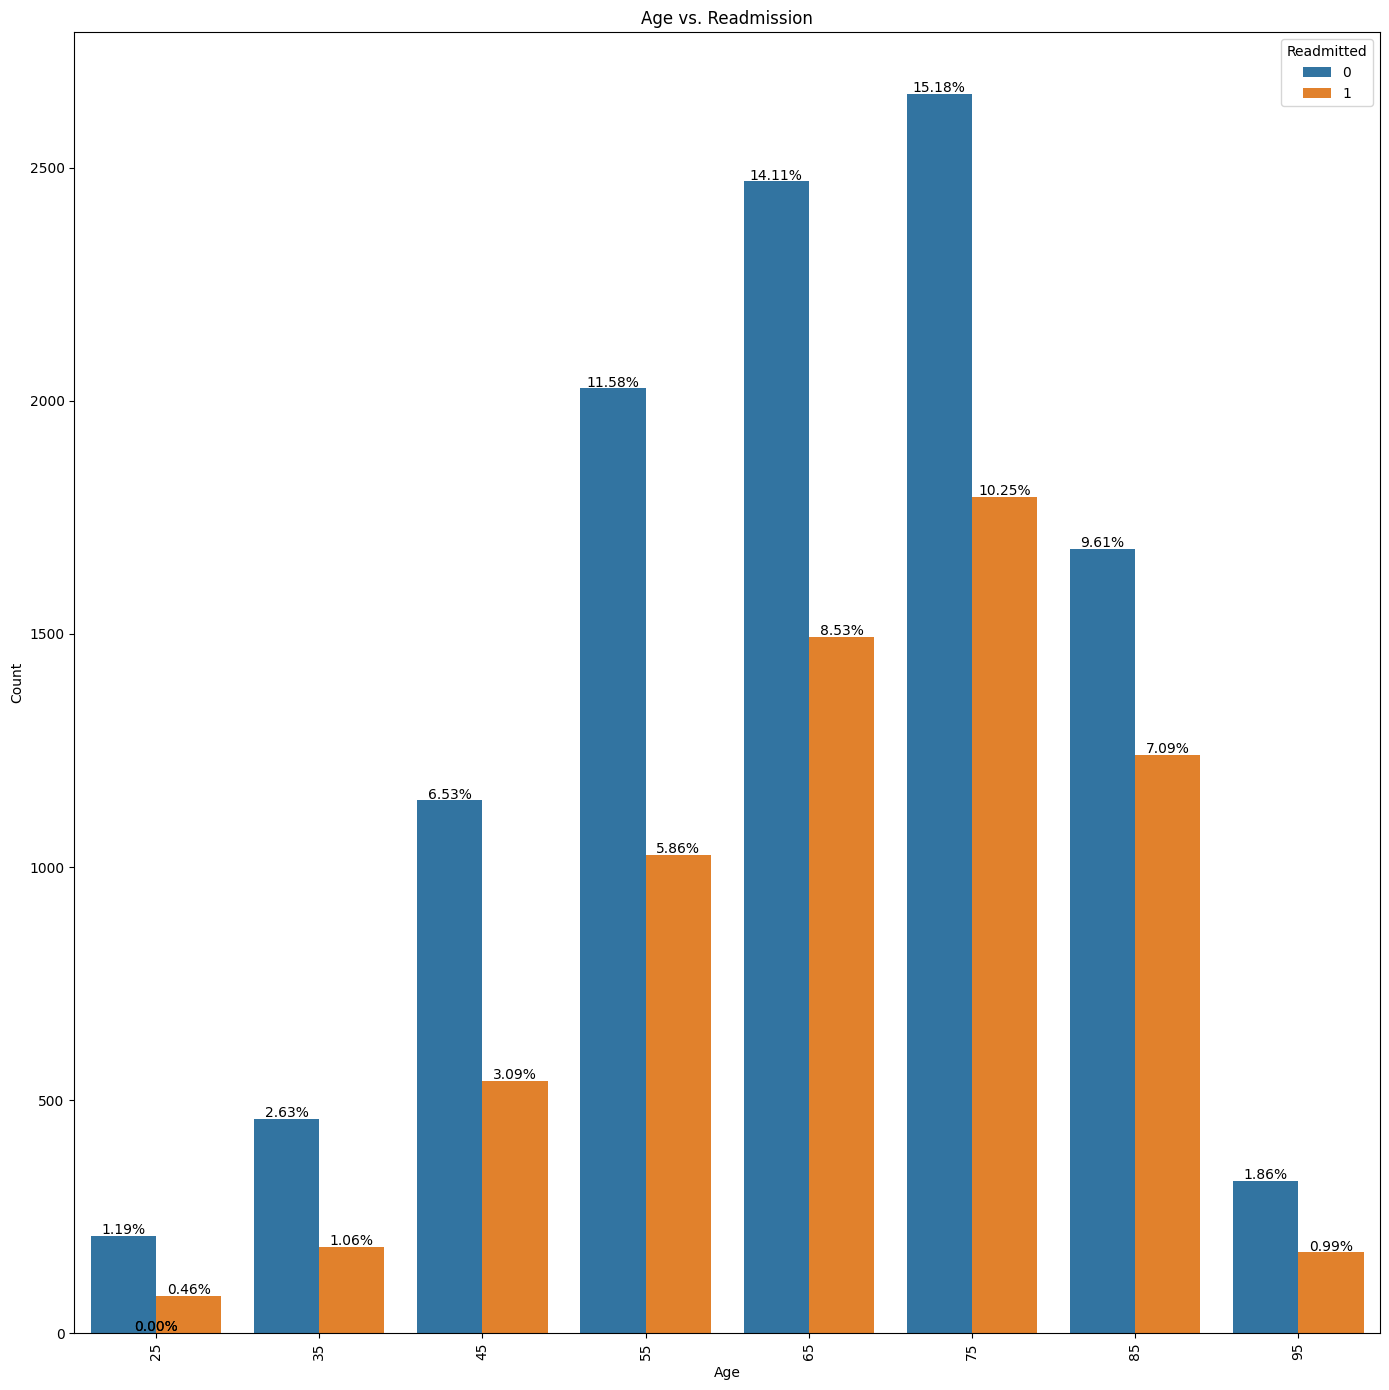

age
75    4452
65    3964
55    3053
85    2923
45    1684
35     645
95     499
25     288
Name: count, dtype: int64


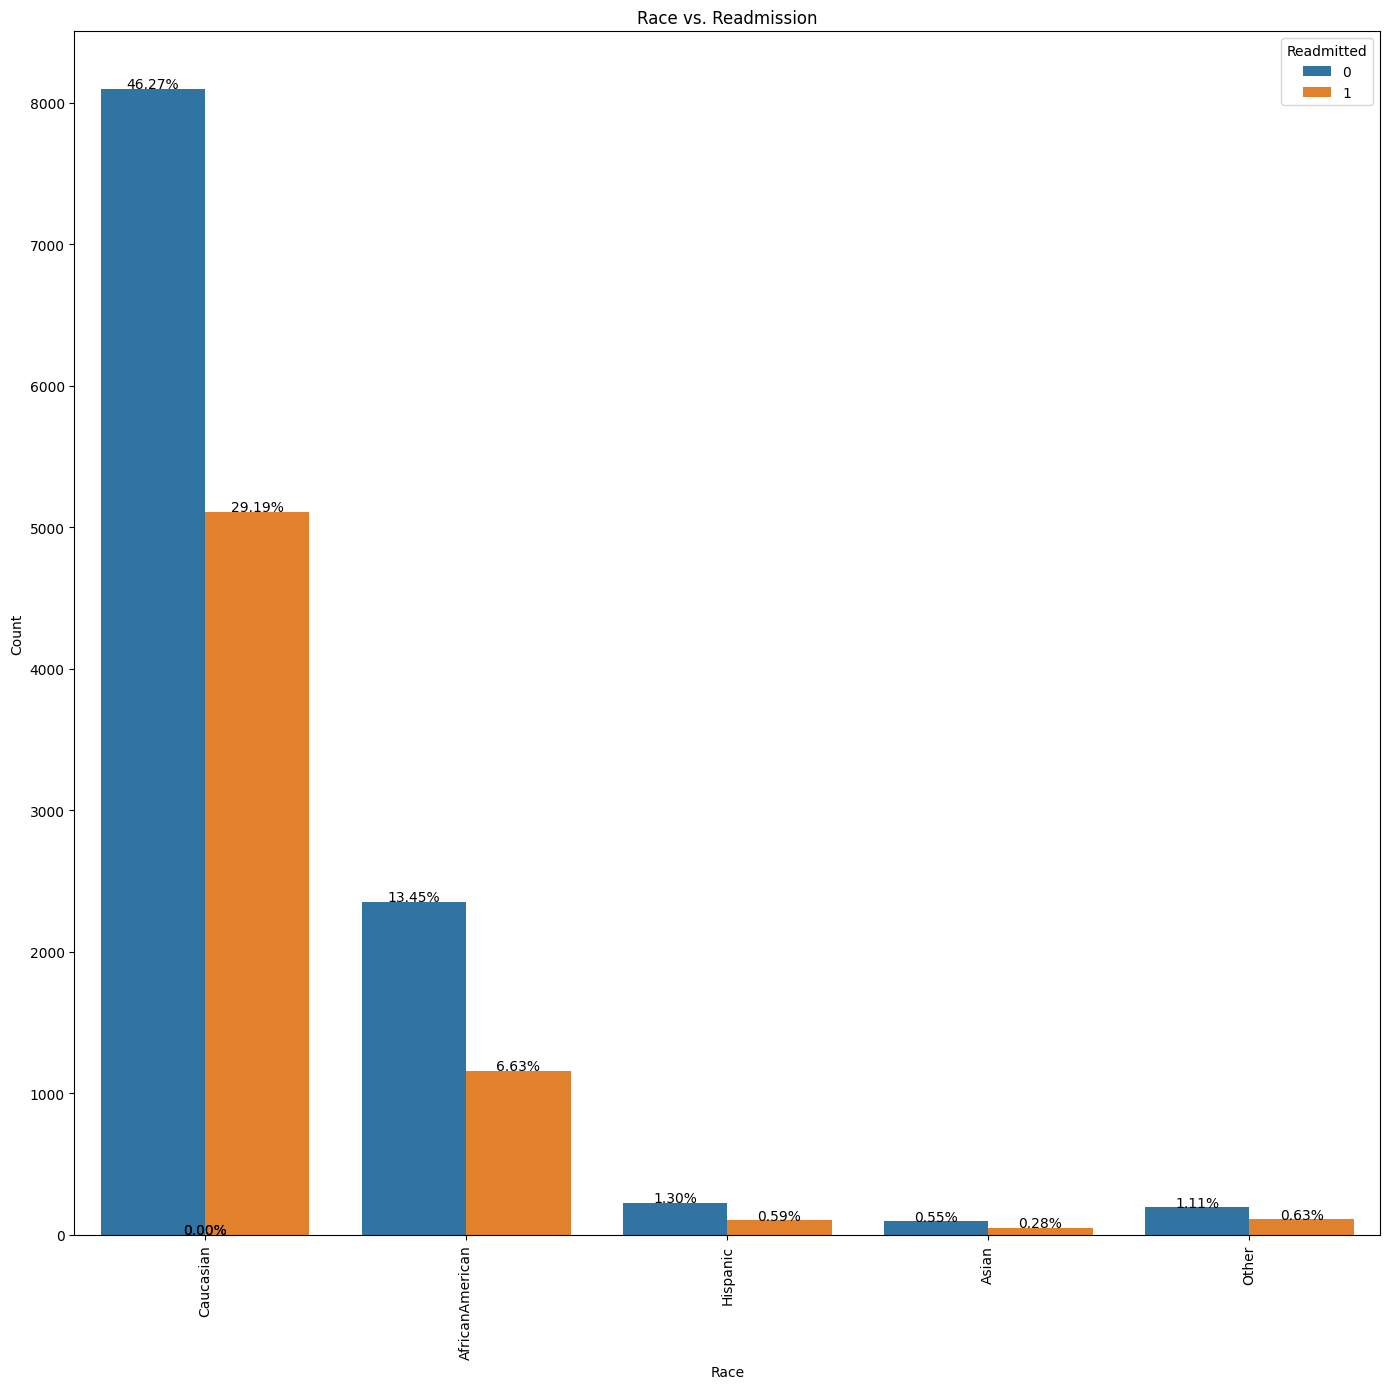

race
Caucasian          13211
AfricanAmerican     3516
Hispanic             331
Other                305
Asian                145
Name: count, dtype: int64


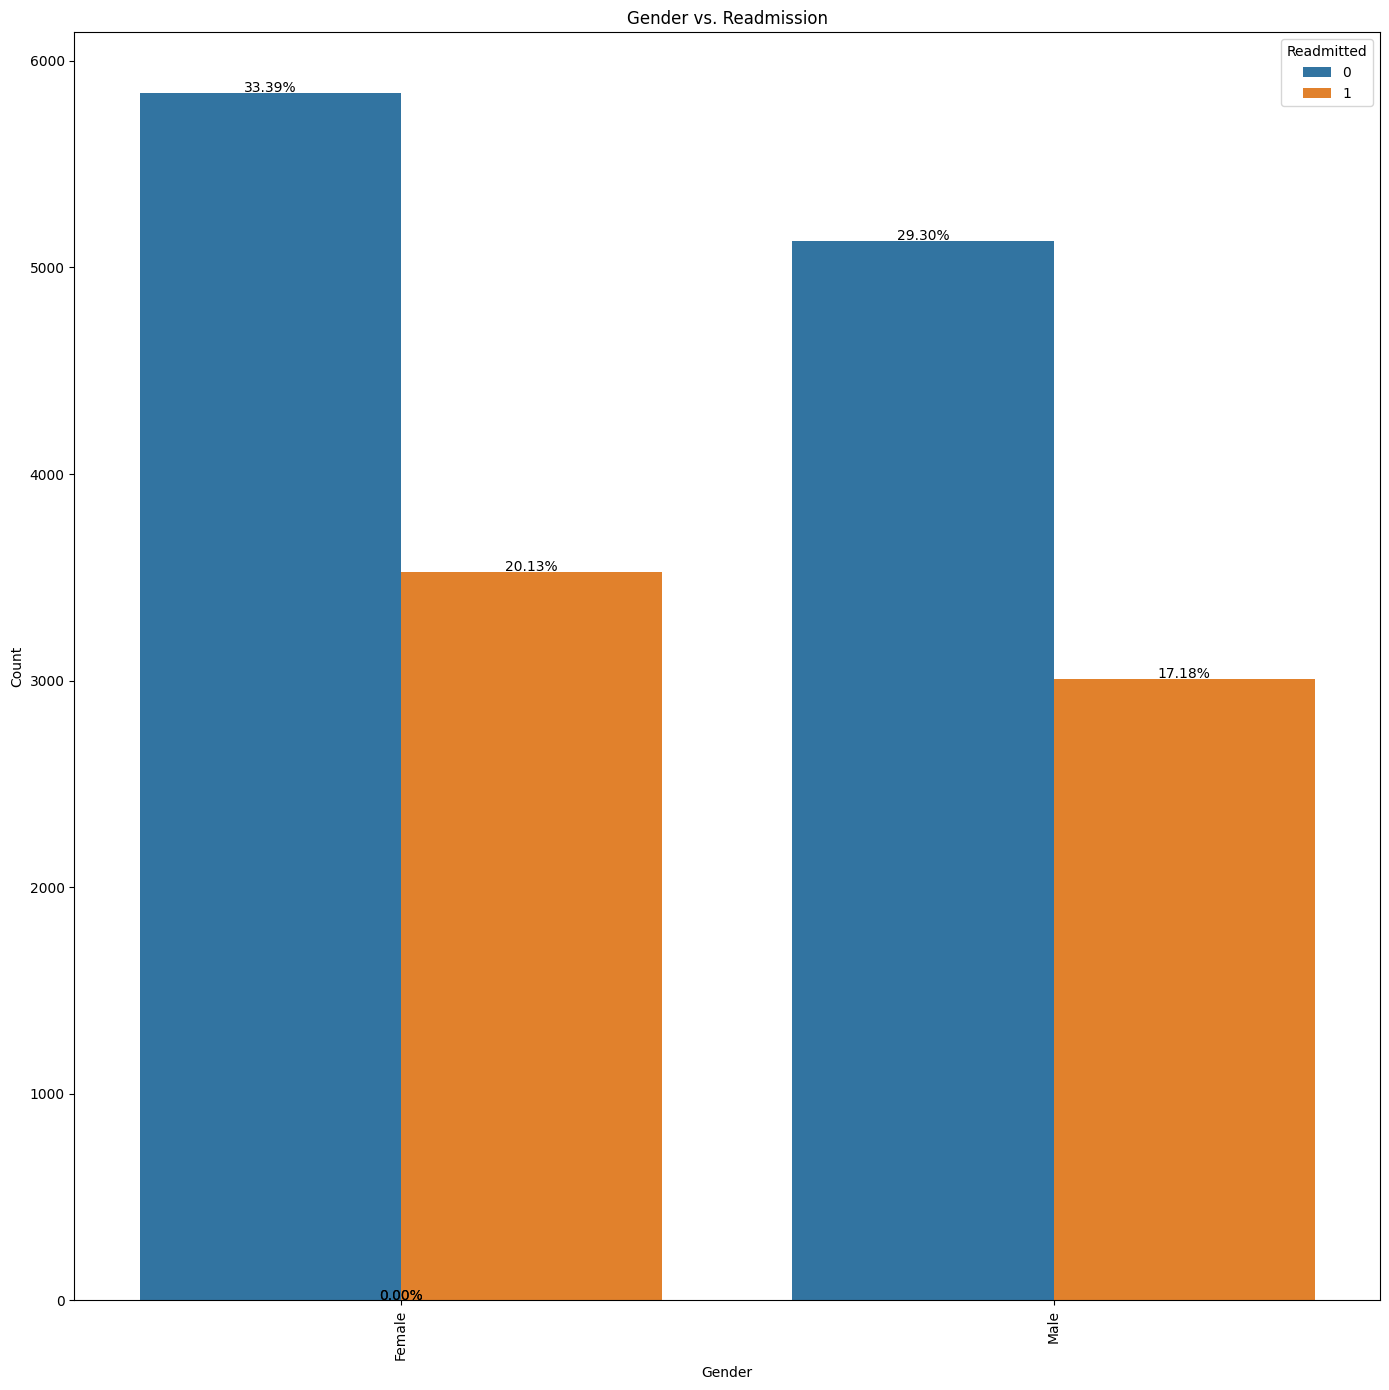

gender
Female    9371
Male      8137
Name: count, dtype: int64


In [14]:
# Visualisations
visualise_categorical_data(df, 'age')

print(df['age'].value_counts())

visualise_categorical_data(df, 'race')

print(df['race'].value_counts())

visualise_categorical_data(df, 'gender')

print(df['gender'].value_counts())

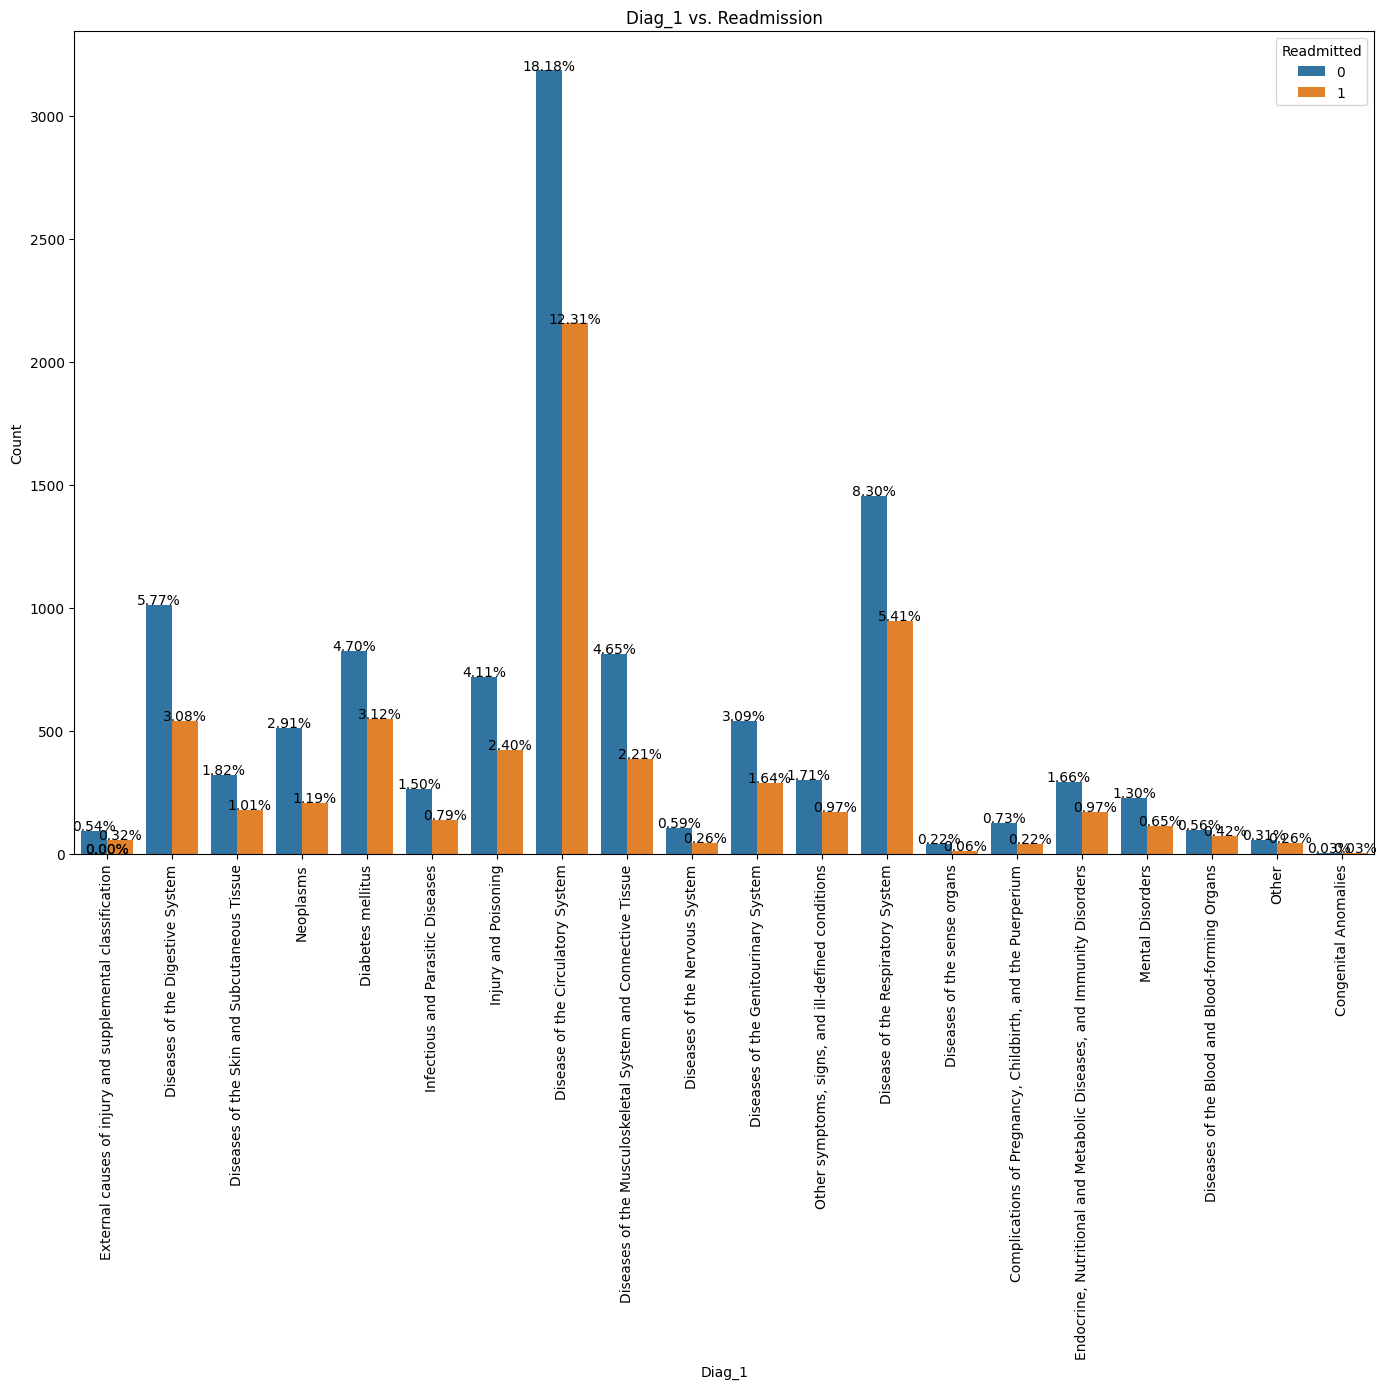

diag_1
Disease of the Circulatory System                                        5338
Disease of the Respiratory System                                        2400
Diseases of the Digestive System                                         1549
Diabetes mellitus                                                        1370
Diseases of the Musculoskeletal System and Connective Tissue             1201
Injury and Poisoning                                                     1141
Diseases of the Genitourinary System                                      829
Neoplasms                                                                 718
Diseases of the Skin and Subcutaneous Tissue                              496
Other symptoms, signs, and ill-defined conditions                         468
Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders     460
Infectious and Parasitic Diseases                                         400
Mental Disorders                                         

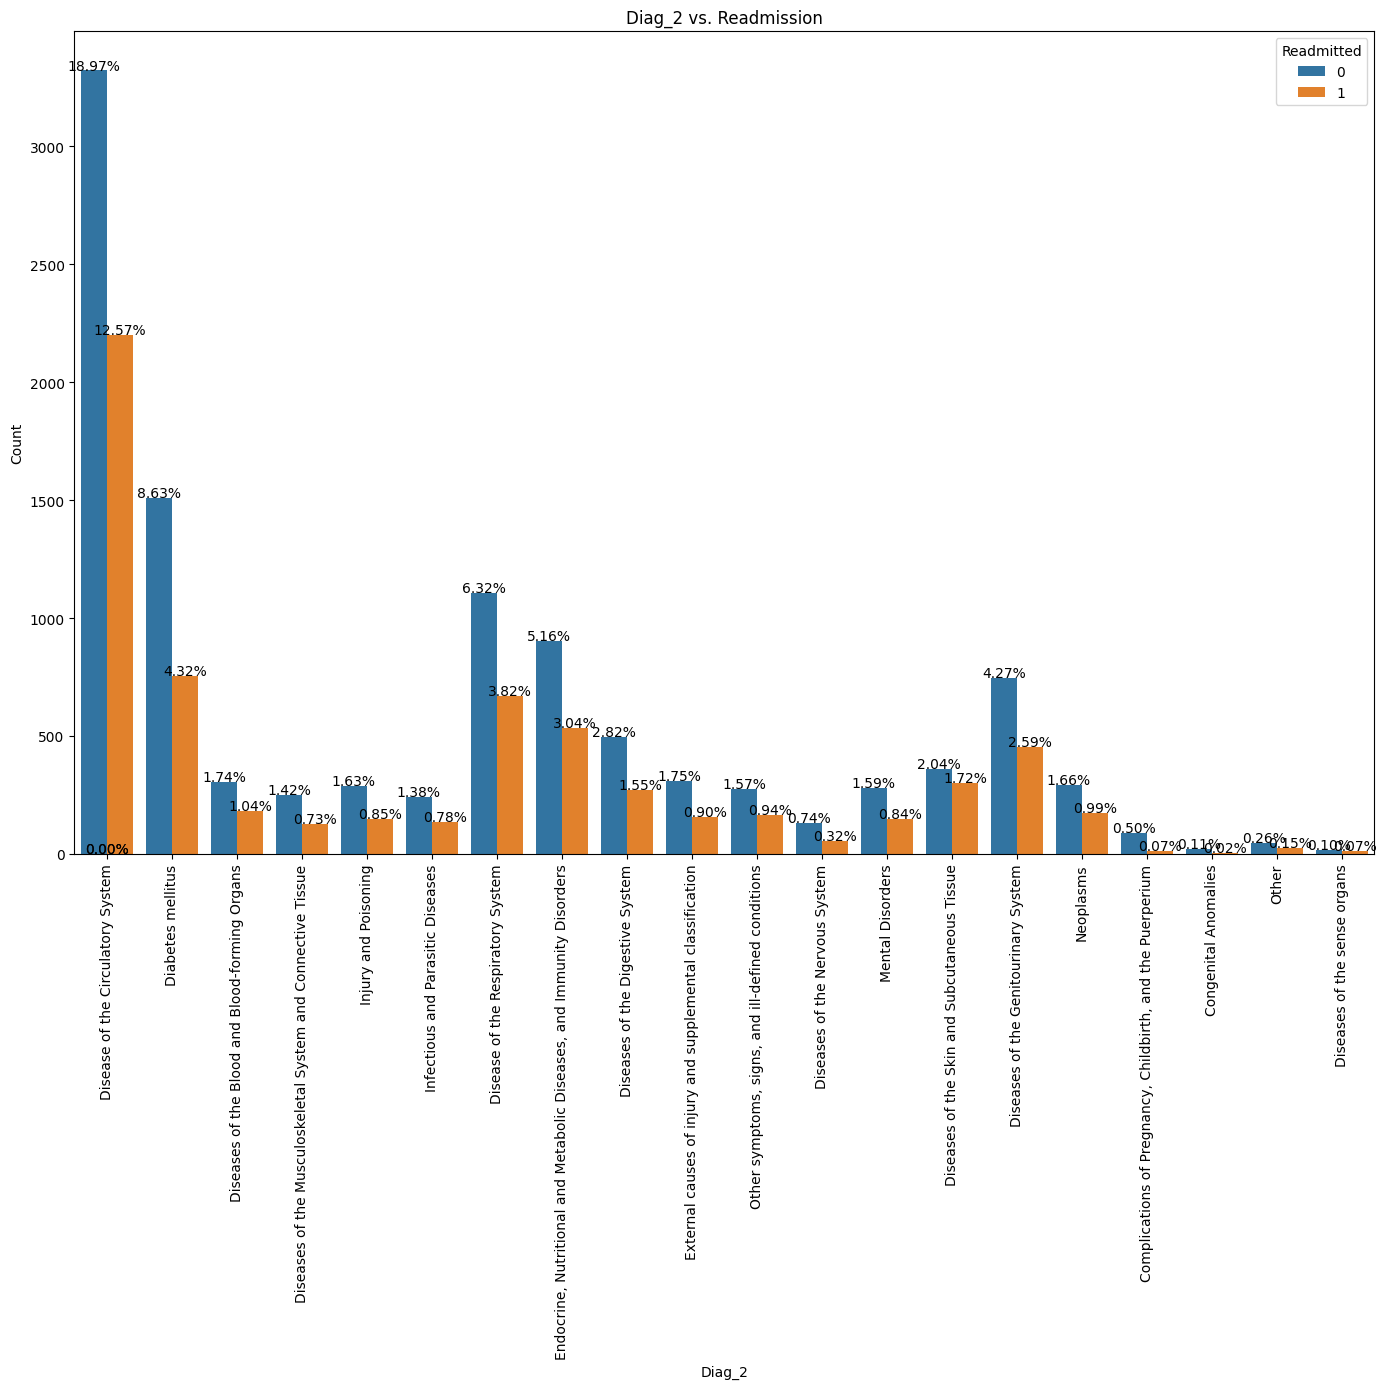

diag_2
Disease of the Circulatory System                                        5523
Diabetes mellitus                                                        2267
Disease of the Respiratory System                                        1775
Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders    1436
Diseases of the Genitourinary System                                     1200
Diseases of the Digestive System                                          766
Diseases of the Skin and Subcutaneous Tissue                              659
Diseases of the Blood and Blood-forming Organs                            486
Neoplasms                                                                 465
External causes of injury and supplemental classification                 465
Other symptoms, signs, and ill-defined conditions                         440
Injury and Poisoning                                                      434
Mental Disorders                                         

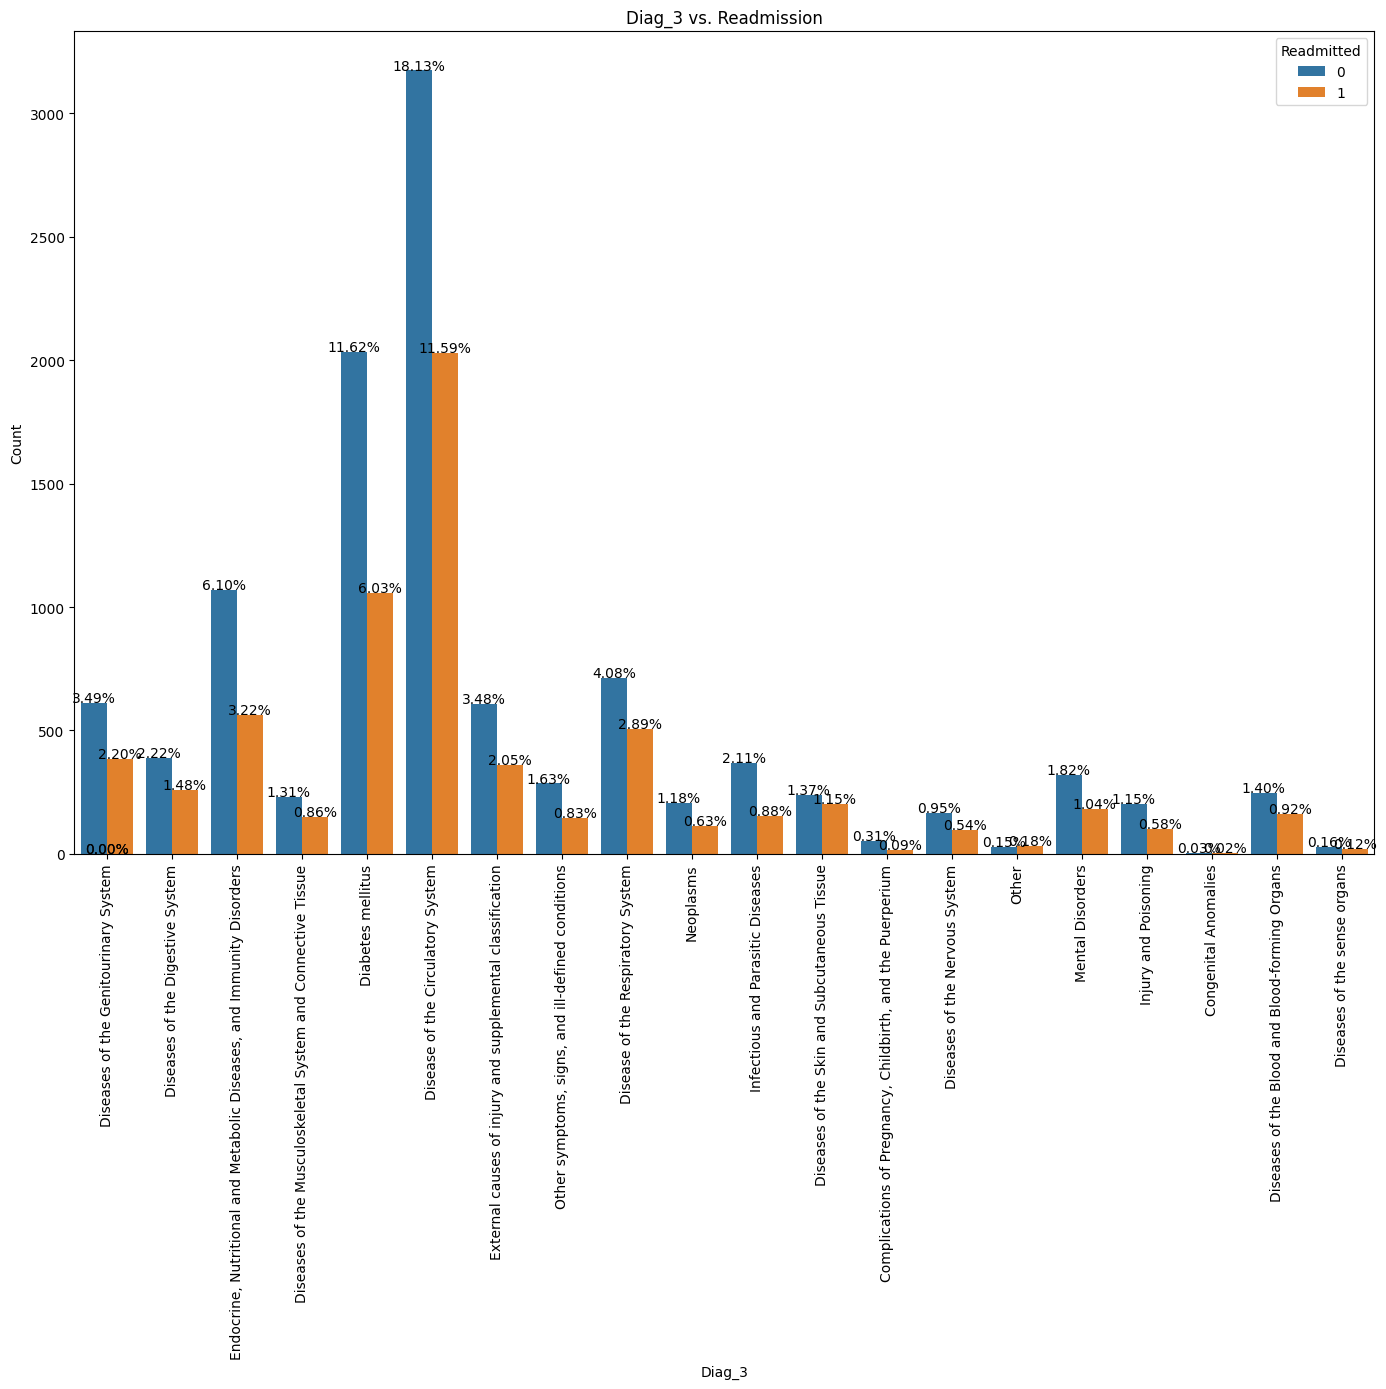

diag_3
Disease of the Circulatory System                                        5204
Diabetes mellitus                                                        3090
Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders    1631
Disease of the Respiratory System                                        1220
Diseases of the Genitourinary System                                      997
External causes of injury and supplemental classification                 968
Diseases of the Digestive System                                          648
Infectious and Parasitic Diseases                                         524
Mental Disorders                                                          501
Diseases of the Skin and Subcutaneous Tissue                              440
Other symptoms, signs, and ill-defined conditions                         430
Diseases of the Blood and Blood-forming Organs                            406
Diseases of the Musculoskeletal System and Connective Tis

In [15]:
# Plotting for diag_1
visualise_categorical_data(df, 'diag_1')

print(df['diag_1'].value_counts())

# Plotting for diag_2
visualise_categorical_data(df, 'diag_2')

print(df['diag_2'].value_counts())

# Plotting for diag_3
visualise_categorical_data(df, 'diag_3')

print(df['diag_3'].value_counts())

## Model Building

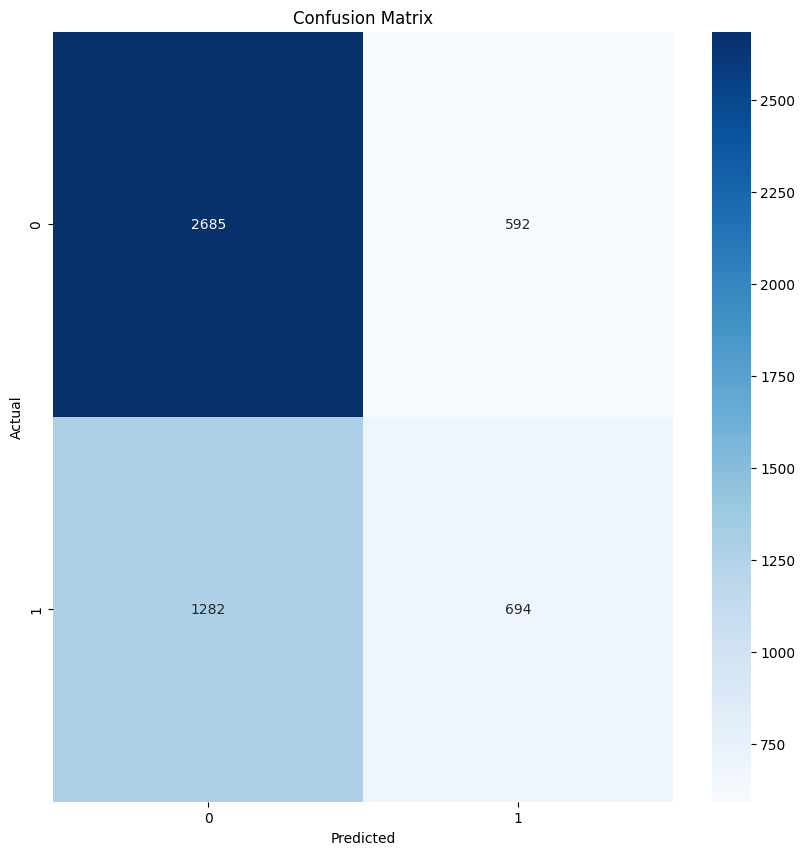

Accuracy: 0.6432514753474206
Precision: 0.5396578538102644
Recall: 0.35121457489878544
F1 Score: 0.42550582464745557
Cross-validation scores: [0.62707025 0.29583095 0.30611079 0.39406054 0.36379212 0.30953741
 0.32781268 0.25014278 0.28171429 0.62685714]
Mean cross-validation score: 0.3782928938565717
RandomForest - OOB Score: 0.6354
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.82      0.74      3277
           1       0.54      0.35      0.43      1976

    accuracy                           0.64      5253
   macro avg       0.61      0.59      0.58      5253
weighted avg       0.63      0.64      0.62      5253



In [16]:
# Selecting the required features for model building
selected_columns = ['num_medications', 'number_outpatient', 'number_emergency', 'time_in_hospital',
                    'number_inpatient', 'encounter_id', 'age', 'num_lab_procedures',
                    'number_diagnoses', 'num_procedures', 'readmitted']

# Creating features (X) and target variable (y)
X = df[selected_columns].drop(columns=['readmitted'])
y = df['readmitted']

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Building the Random Forest Classifier model
model = RandomForestClassifier(oob_score=True, random_state=0)
model.fit(X_train, y_train)

# Prediction on the test set
y_pred = model.predict(X_test)

# Calculating and plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Evaluating the model using additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Evaluating the model using cross-validation
cv_scores = cross_val_score(model, X, y, cv=10)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())
# Print the OOB score
print(f'RandomForest - OOB Score: {model.oob_score_:.4f}')
# Printing the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# IMPROVED MODEL PART 2

## Exploratory Analysis Part 2

In [17]:
# Import the packages 
import IPython
import scipy as sp
from statistics import mode
from scipy.stats import norm

In [18]:
# Read the dataset
data = pd.read_csv("diabetic_data.csv")

# Check the size
data.shape

(101766, 50)

In [19]:
# Check the dataset data types and null values.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [20]:
# NO null values

# Check the data types only for object types.
for i in data.columns:
    if data[i].dtype==object:
        d= data[i].value_counts()
        print(pd.DataFrame(data=d))

                 count
race                  
Caucasian        76099
AfricanAmerican  19210
?                 2273
Hispanic          2037
Other             1506
Asian              641
                 count
gender                
Female           54708
Male             47055
Unknown/Invalid      3
          count
age            
[70-80)   26068
[60-70)   22483
[50-60)   17256
[80-90)   17197
[40-50)    9685
[30-40)    3775
[90-100)   2793
[20-30)    1657
[10-20)     691
[0-10)      161
           count
weight          
?          98569
[75-100)    1336
[50-75)      897
[100-125)    625
[125-150)    145
[25-50)       97
[0-25)        48
[150-175)     35
[175-200)     11
>200           3
            count
payer_code       
?           40256
MC          32439
HM           6274
SP           5007
BC           4655
MD           3532
CP           2533
UN           2448
CM           1937
OG           1033
PO            592
DM            549
CH            146
WC            135
OT             95

In [21]:
# There are no null values in the dataset.

# Check the numerical data values 
data.describe().transpose()

count          mean           std      min  \
encounter_id              101766.0  1.652016e+08  1.026403e+08  12522.0   
patient_nbr               101766.0  5.433040e+07  3.869636e+07    135.0   
admission_type_id         101766.0  2.024006e+00  1.445403e+00      1.0   
discharge_disposition_id  101766.0  3.715642e+00  5.280166e+00      1.0   
admission_source_id       101766.0  5.754437e+00  4.064081e+00      1.0   
time_in_hospital          101766.0  4.395987e+00  2.985108e+00      1.0   
num_lab_procedures        101766.0  4.309564e+01  1.967436e+01      1.0   
num_procedures            101766.0  1.339730e+00  1.705807e+00      0.0   
num_medications           101766.0  1.602184e+01  8.127566e+00      1.0   
number_outpatient         101766.0  3.693572e-01  1.267265e+00      0.0   
number_emergency          101766.0  1.978362e-01  9.304723e-01      0.0   
number_inpatient          101766.0  6.355659e-01  1.262863e+00      0.0   
number_diagnoses          101766.0  7.422607e+00  1.933600e+00      1.0   

                                 25%          50%           75%          max  
encounter_id              84961194.0  152388987.0  2.302709e+08  443867222.0  
patient_nbr               23413221.0   45505143.0  8.754595e+07  189502619.0  
admission_type_id                1.0          1.0  3.000000e+00          8.0  
discharge_disposition_id         1.0          1.0  4.000000e+00         28.0  
admission_source_id              1.0          7.0  7.000000e+00         25.0  
time_in_hospital                 2.0          4.0  6.000000e+00         14.0  
num_lab_procedures              31.0         44.0  5.700000e+01        132.0  
num_procedures                   0.0          1.0  2.000000e+00          6.0  
num_medications                 10.0         15.0  2.000000e+01         81.0  
number_outpatient                0.0          0.0  0.000000e+00         42.0  
number_emergency                 0.0          0.0  0.000000e+00         76.0  
number_inpatient                 0.0          0.0  1.000000e+00         21.0  
number_diagnoses                 6.0          8.0  9.000000e+00         16.0

In [22]:
# The data shows that the longest hospital stay recorded is 14 days.
# 'encounter_id' and 'patient_nbr' need to be treated or dropped. 
# On average, the number of lab procedures is 43. 
# Additionally, patients are typically prescribed an average of 16 medications
# The mean of diagnoses made is approximately 7.4.

In [23]:
# Count the occurrences of each category in the 'readmitted' column.
target_count=data['readmitted'].value_counts()

<Axes: title={'center': 'Readmission_count'}, xlabel='readmitted'>

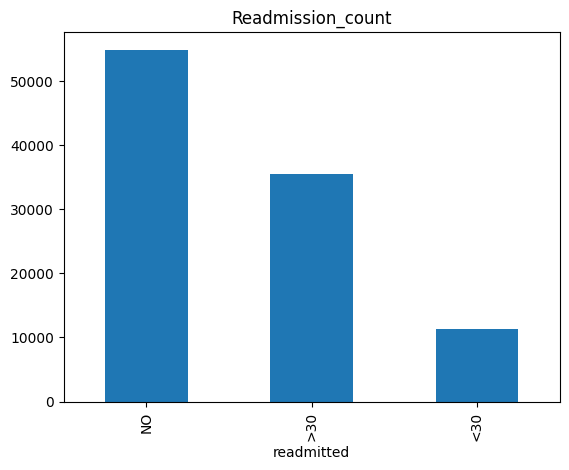

In [24]:
# Plot the count of each category as a bar plot
target_count.plot(kind='bar', title='Readmission_count')

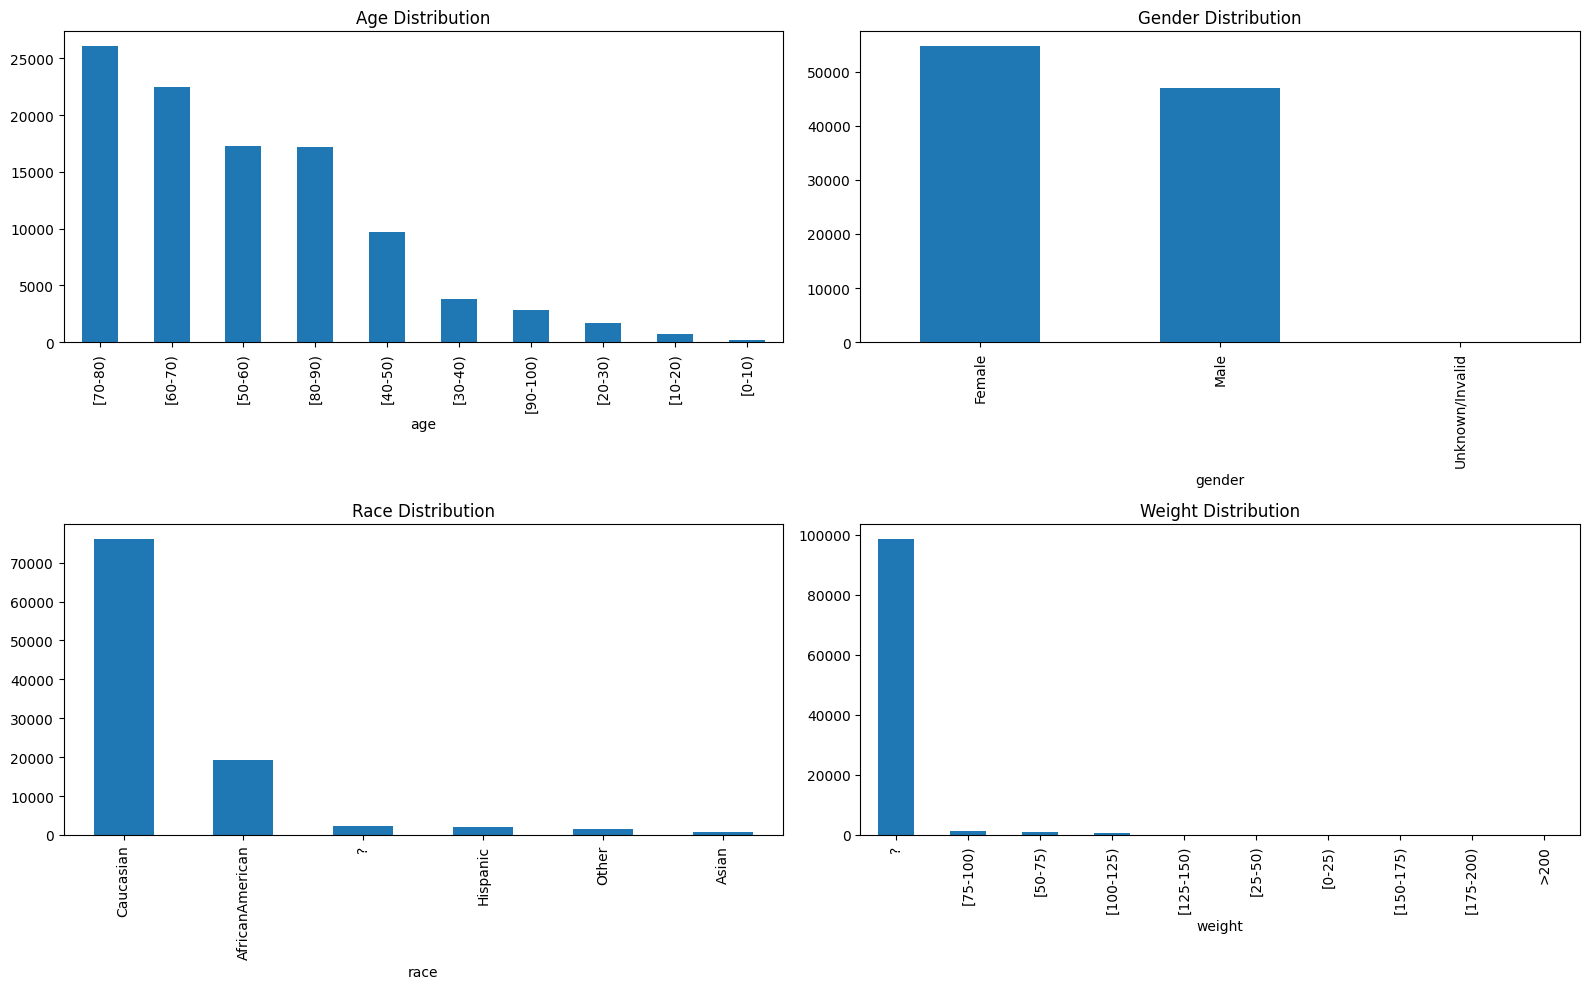

In [25]:
# Figure and axes for the plots
fig = plt.figure(figsize=(16, 10))

# Count occurrences for age and gender
age_count = data['age'].value_counts()
gender_count = data['gender'].value_counts()

# Subplot for age distribution
ax_age = fig.add_subplot(2, 2, 1)
age_count.plot(kind='bar', title='Age Distribution', ax=ax_age)

# Subplot for gender distribution
ax_gender = fig.add_subplot(2, 2, 2)
gender_count.plot(kind='bar', title='Gender Distribution', ax=ax_gender)

# Count occurrences for race and weight
race_count = data['race'].value_counts()
weight_count = data['weight'].value_counts()

# Subplot for race distribution
ax_race = fig.add_subplot(2, 2, 3)
race_count.plot(kind='bar', title='Race Distribution', ax=ax_race)

# Subplot for weight distribution
ax_weight = fig.add_subplot(2, 2, 4)
weight_count.plot(kind='bar', title='Weight Distribution', ax=ax_weight)

plt.tight_layout()

In [26]:
# Retrieve numerical columns excluding the 'readmitted' column.
num_col = list(set(list(data._get_numeric_data().columns))- {'readmitted'})

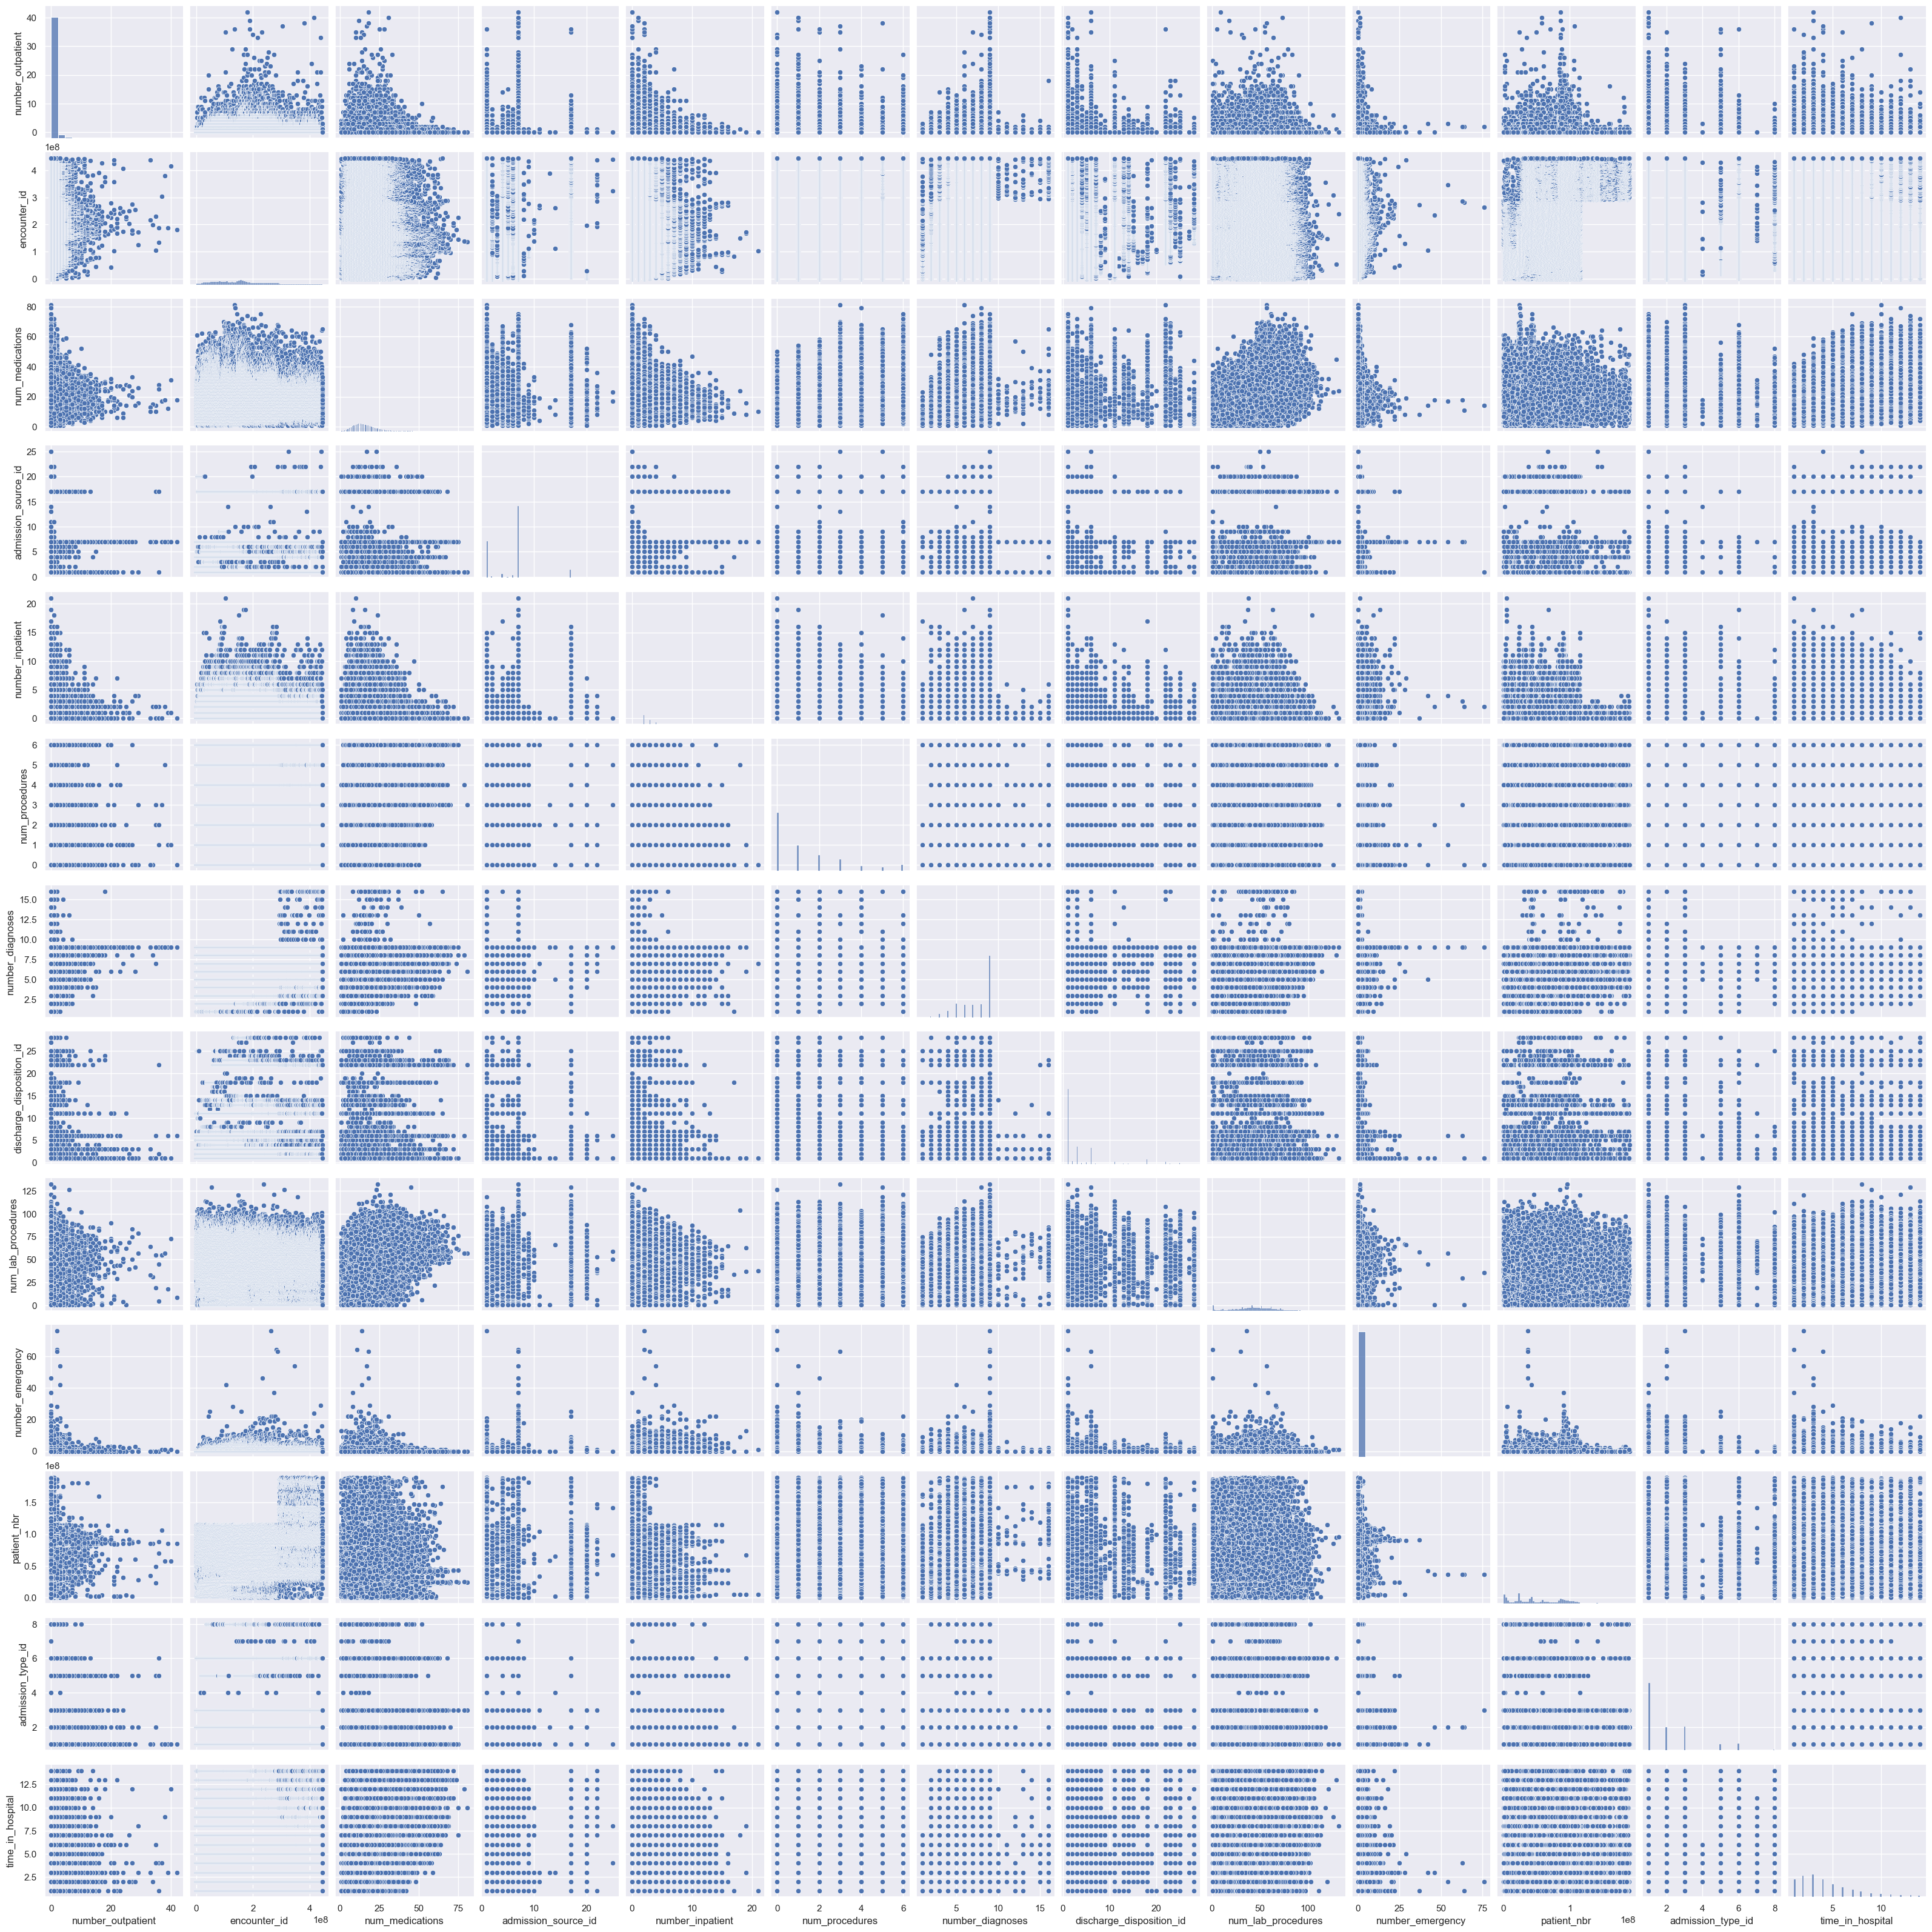

In [27]:
sns.set()

# Plot the numerical features
sns.pairplot(data[num_col], height = 2.5)
plt.show()

## Enhanced Data Preprocessing

In [28]:
# Copy of the file for pre-processing 
train = data.copy(deep=True)

# Initialize an empty list to store the results.
missing_data = []

In [29]:
# Identify object columns
object_cols = train.select_dtypes(include=['object']).columns
# Check the percentage of missing values for each column.
for col in object_cols:
    count_missing = train[col][train[col] == '?'].count()
    percent_missing = (count_missing / train.shape[0] * 100).round(2)
    missing_data.append([col, count_missing, percent_missing])

In [30]:
# Create a DataFrame from the list and sort it by the percentage of missing values in descending order.
missing_value = pd.DataFrame(missing_data, columns=["col", "count_missing", "percent_missing"]).sort_values(by="percent_missing", ascending=False)
missing_value

col  count_missing  percent_missing
3                     weight          98569            96.86
5          medical_specialty          49949            49.08
4                 payer_code          40256            39.56
0                       race           2273             2.23
8                     diag_3           1423             1.40
7                     diag_2            358             0.35
6                     diag_1             21             0.02
29       glyburide-metformin              0             0.00
24              troglitazone              0             0.00
25                tolazamide              0             0.00
26                   examide              0             0.00
27               citoglipton              0             0.00
28                   insulin              0             0.00
33    metformin-pioglitazone              0             0.00
30       glipizide-metformin              0             0.00
31  glimepiride-pioglitazone              0             0.00
32   metformin-rosiglitazone              0             0.00
22                  acarbose              0             0.00
34                    change              0             0.00
35               diabetesMed              0             0.00
23                  miglitol              0             0.00
18                 glyburide              0             0.00
21             rosiglitazone              0             0.00
20              pioglitazone              0             0.00
19               tolbutamide              0             0.00
1                     gender              0             0.00
17                 glipizide              0             0.00
16             acetohexamide              0             0.00
15               glimepiride              0             0.00
14            chlorpropamide              0             0.00
13               nateglinide              0             0.00
12               repaglinide              0             0.00
11                 metformin              0             0.00
10                 A1Cresult              0             0.00
9              max_glu_serum              0             0.00
2                        age              0             0.00
36                readmitted              0             0.00

In [31]:
# Drop the irrelavant and high missing value variables
train = train.drop(columns=['weight', 'medical_specialty', 'payer_code','encounter_id','citoglipton','examide'],axis=1)
# Drop only the missing values if missing in all three diagonosis categories 
train = train.drop(set(train[(train['diag_1']== '?') & (train['diag_2'] == '?') & (train['diag_3'] == '?')].index))
# Drop the expired patients
train = train.drop(train[train['discharge_disposition_id'].isin([11, 19, 20, 21])].index)
# Drop duplicated patients
train = train.drop_duplicates(subset='patient_nbr')
# Irrelevant variable
train=train.drop(['patient_nbr'],axis=1)

train.shape

(70438, 43)

In [32]:
print(train['gender'].value_counts())

gender
Female             37470
Male               32965
Unknown/Invalid        3
Name: count, dtype: int64


In [33]:
#Replacing missing values
train = train.drop(set(train['gender'][train['gender'] == 'Unknown/Invalid'].index))

# Replacing missing values in race with Other category
train['race'] = train['race'].replace('?', 'Other')

train.shape

(70435, 43)

In [34]:
# Adding 'patient_service' to track how much hospital care patients receive overall.
# Creating 'med_change' to measure changes in patients medication doses over time.
# Introducing 'num_med' to count how many different medications each patient is taking.

# 'patient_service' sums the counts of outpatient visits, emergency visits, and inpatient admissions.
train['patient_service'] = train['number_outpatient'] + train['number_emergency'] + train['number_inpatient']

In [35]:
# List of medications
keys = ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", 
    "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", 
    "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide", 
    "insulin", "glyburide-metformin", "glipizide-metformin", 
    "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"]

# Transform medication to binary and sum up
# Initialize 'med_change' to zero before looping
train['med_change'] = 0

# Loop over each medication convert and sum
for medication in keys:
    new_col_name = medication + 'new'
    train[new_col_name] = train[medication].map(lambda x: 0 if x in ['No', 'Steady'] else 1)
    train['med_change'] += train[new_col_name]

# Remove temporary columns
train.drop(columns=[key + 'new' for key in keys], inplace=True)

# Display the 'med_change' count of each value
train['med_change'].value_counts(dropna=False)


med_change
0    53072
1    16360
2      926
3       74
4        3
Name: count, dtype: int64

In [36]:
# Calculating the number of medications used for each patient
# Replace categorical values
med_map = {'No': 0, 'Steady': 1, 'Up': 1, 'Down': 1}

for col in keys:
    train[col] = train[col].map(med_map)

#Initialize 'num_med' column to count medications per patient
train['num_med'] = 0

# Increment 'num_med' by the medication value for each patient
for col in keys:
    train['num_med'] = train['num_med'] + train[col]
    
# Check the distribution of 'num_med' for the occurrences of each value.
train['num_med'].value_counts(dropna=False)

num_med
1    31370
0    16825
2    15503
3     5679
4     1004
5       50
6        4
Name: count, dtype: int64

In [37]:
# diag_1 now primary diagnosis, diag_2 now secondary diagnosis, and diag_3 now additional diagnosis.

# Duplicating the diagnosis columns
train['primary_diag'] = train['diag_1']
train['secondary_diag'] = train['diag_2']
train['additional_diag'] = train['diag_3']

In [38]:
# Replacing the "?" with -1 in diagnosis columns
diagnosis_columns = ['primary_diag', 'secondary_diag', 'additional_diag']
for column in diagnosis_columns:
    train[column] = train[column].replace('?', -1)

In [39]:
# Recoding ICD codes for V or E to the “other” category = 0
def recode_ve_to_zero(value):
    if isinstance(value, str) and (value.startswith('V') or value.startswith('E')):
        return 0
    else:
        return value

# Apply the function to each diagnosis
for column in diagnosis_columns:
    train[column] = train[column].apply(recode_ve_to_zero)

# convert the data type to float for later computation
for column in diagnosis_columns:
    train[column] = train[column].astype(float)

In [40]:
# recoding ICD codes diag1,diag2,diag3 to categories
for index, row in train.iterrows():
    if (row['primary_diag'] >= 390 and row['primary_diag'] < 460) or (np.floor(row['primary_diag']) == 785):
        train.loc[index, 'primary_diag'] = 1
    elif (row['primary_diag'] >= 460 and row['primary_diag'] < 520) or (np.floor(row['primary_diag']) == 786):
        train.loc[index, 'primary_diag'] = 2
    elif (row['primary_diag'] >= 520 and row['primary_diag'] < 580) or (np.floor(row['primary_diag']) == 787):
        train.loc[index, 'primary_diag'] = 3
    elif (np.floor(row['primary_diag']) == 250):
        train.loc[index, 'primary_diag'] = 4
    elif (row['primary_diag'] >= 800 and row['primary_diag'] < 1000):
        train.loc[index, 'primary_diag'] = 5
    elif (row['primary_diag'] >= 710 and row['primary_diag'] < 740):
        train.loc[index, 'primary_diag'] = 6
    elif (row['primary_diag'] >= 580 and row['primary_diag'] < 630) or (np.floor(row['primary_diag']) == 788):
        train.loc[index, 'primary_diag'] = 7
    elif (row['primary_diag'] >= 140 and row['primary_diag'] < 240):
        train.loc[index, 'primary_diag'] = 8
    else:
        train.loc[index, 'primary_diag'] = 0

for index, row in train.iterrows():
    if (row['secondary_diag'] >= 390 and row['secondary_diag'] < 460) or (np.floor(row['secondary_diag']) == 785):
        train.loc[index, 'secondary_diag'] = 1
    elif (row['secondary_diag'] >= 460 and row['secondary_diag'] < 520) or (np.floor(row['secondary_diag']) == 786):
        train.loc[index, 'secondary_diag'] = 2
    elif (row['secondary_diag'] >= 520 and row['secondary_diag'] < 580) or (np.floor(row['secondary_diag']) == 787):
        train.loc[index, 'secondary_diag'] = 3
    elif (np.floor(row['secondary_diag']) == 250):
        train.loc[index, 'secondary_diag'] = 4
    elif (row['secondary_diag'] >= 800 and row['secondary_diag'] < 1000):
        train.loc[index, 'secondary_diag'] = 5
    elif (row['secondary_diag'] >= 710 and row['secondary_diag'] < 740):
        train.loc[index, 'secondary_diag'] = 6
    elif (row['secondary_diag'] >= 580 and row['secondary_diag'] < 630) or (np.floor(row['secondary_diag']) == 788):
        train.loc[index, 'secondary_diag'] = 7
    elif (row['secondary_diag'] >= 140 and row['secondary_diag'] < 240):
        train.loc[index, 'secondary_diag'] = 8
    else:
        train.loc[index, 'secondary_diag'] = 0

for index, row in train.iterrows():
    if (row['additional_diag'] >= 390 and row['additional_diag'] < 460) or (np.floor(row['additional_diag']) == 785):
        train.loc[index, 'additional_diag'] = 1
    elif (row['additional_diag'] >= 460 and row['additional_diag'] < 520) or (np.floor(row['additional_diag']) == 786):
        train.loc[index, 'additional_diag'] = 2
    elif (row['additional_diag'] >= 520 and row['additional_diag'] < 580) or (np.floor(row['additional_diag']) == 787):
        train.loc[index, 'additional_diag'] = 3
    elif (np.floor(row['additional_diag']) == 250):
        train.loc[index, 'additional_diag'] = 4
    elif (row['additional_diag'] >= 800 and row['additional_diag'] < 1000):
        train.loc[index, 'additional_diag'] = 5
    elif (row['additional_diag'] >= 710 and row['additional_diag'] < 740):
        train.loc[index, 'additional_diag'] = 6
    elif (row['additional_diag'] >= 580 and row['additional_diag'] < 630) or (np.floor(row['additional_diag']) == 788):
        train.loc[index, 'additional_diag'] = 7
    elif (row['additional_diag'] >= 140 and row['additional_diag'] < 240):
        train.loc[index, 'additional_diag'] = 8
    else:
        train.loc[index, 'additional_diag'] = 0

In [41]:
# Display the difference of diagnosis columuns 1/2/3
train[['diag_1', 'primary_diag']].head(15).T

0    1    2    3    4    5    6    7    8    9      10   11  \
diag_1        250.83  276  648    8  197  414  414  428  398  434  250.7  157   
primary_diag     4.0  0.0  0.0  0.0  8.0  1.0  1.0  1.0  1.0  1.0    4.0  8.0   

               12   13   14  
diag_1        428  428  518  
primary_diag  1.0  1.0  2.0

In [42]:
train[['diag_2','secondary_diag']].head(15).T

0       1    2       3    4    5    6    7    8    9    10  \
diag_2            ?  250.01  250  250.43  157  411  411  492  427  198  403   
secondary_diag  0.0     4.0  4.0     4.0  8.0  1.0  1.0  2.0  1.0  8.0  1.0   

                 11      12   13   14  
diag_2          288  250.43  411  998  
secondary_diag  0.0     4.0  1.0  5.0

In [43]:
train[['diag_3','additional_diag']].head(15).T

0    1    2    3    4    5    6    7    8    9    10   11  \
diag_3             ?  255  V27  403  250  250  V45  250   38  486  996  197   
additional_diag  0.0  0.0  0.0  1.0  4.0  4.0  0.0  4.0  0.0  2.0  5.0  8.0   

                    12   13   14  
diag_3           250.6  427  627  
additional_diag    4.0  1.0  7.0

In [44]:
# Show the distribution of 'admission_type_id' column.
train['admission_type_id'].value_counts(dropna=False)

admission_type_id
1    35770
3    13835
2    12860
6     4530
5     3122
8      291
7       18
4        9
Name: count, dtype: int64

In [45]:
# Recategorising admission type id for narrowing
train['admission_type_id'] = train['admission_type_id'].replace(2,1)
train['admission_type_id'] = train['admission_type_id'].replace(7,1)
train['admission_type_id'] = train['admission_type_id'].replace(6,5)
train['admission_type_id'] = train['admission_type_id'].replace(8,5)

In [46]:
# Analysing the distribution in 'discharge_disposition_id'.
train['discharge_disposition_id'].value_counts(dropna=False)

discharge_disposition_id
1     44315
3      8787
6      8290
18     2474
2      1540
22     1409
5       913
25      778
4       541
7       409
23      260
13      242
14      218
28       90
8        73
15       40
24       25
9         9
17        8
10        6
16        3
27        3
12        2
Name: count, dtype: int64

In [47]:
# Recategorising discharge_disposition_id for narrowing
train['discharge_disposition_id'] = train['discharge_disposition_id'].replace(6,1)
train['discharge_disposition_id'] = train['discharge_disposition_id'].replace(8,1)
train['discharge_disposition_id'] = train['discharge_disposition_id'].replace(9,1)
train['discharge_disposition_id'] = train['discharge_disposition_id'].replace(13,1)
train['discharge_disposition_id'] = train['discharge_disposition_id'].replace(3,2)
train['discharge_disposition_id'] = train['discharge_disposition_id'].replace(4,2)
train['discharge_disposition_id'] = train['discharge_disposition_id'].replace(5,2)
train['discharge_disposition_id'] = train['discharge_disposition_id'].replace(14,2)
train['discharge_disposition_id'] = train['discharge_disposition_id'].replace(22,2)
train['discharge_disposition_id'] = train['discharge_disposition_id'].replace(23,2)
train['discharge_disposition_id'] = train['discharge_disposition_id'].replace(24,2)
train['discharge_disposition_id'] = train['discharge_disposition_id'].replace(12,10)
train['discharge_disposition_id'] = train['discharge_disposition_id'].replace(15,10)
train['discharge_disposition_id'] = train['discharge_disposition_id'].replace(16,10)
train['discharge_disposition_id'] = train['discharge_disposition_id'].replace(17,10)
train['discharge_disposition_id'] = train['discharge_disposition_id'].replace(25,18)
train['discharge_disposition_id'] = train['discharge_disposition_id'].replace(26,18)

In [48]:
# Analysing the distribution in 'admission_source_id'.
train['admission_source_id'].value_counts(dropna=False)

admission_source_id
7     37565
1     21849
17     4858
4      2540
6      1788
2       909
5       514
20      153
3       136
9        95
8        11
10        7
22        4
14        2
25        2
11        1
13        1
Name: count, dtype: int64

In [49]:
# Recategorising admission_source_id for narrowing
train['admission_source_id'] = train['admission_source_id'].replace(2,1)
train['admission_source_id'] = train['admission_source_id'].replace(3,1)
train['admission_source_id'] = train['admission_source_id'].replace(5,4)
train['admission_source_id'] = train['admission_source_id'].replace(6,4)
train['admission_source_id'] = train['admission_source_id'].replace(10,4)
train['admission_source_id'] = train['admission_source_id'].replace(22,4)
train['admission_source_id'] = train['admission_source_id'].replace(25,4)
train['admission_source_id'] = train['admission_source_id'].replace(15,9)
train['admission_source_id'] = train['admission_source_id'].replace(17,9)
train['admission_source_id'] = train['admission_source_id'].replace(20,9)
train['admission_source_id'] = train['admission_source_id'].replace(21,9)
train['admission_source_id'] = train['admission_source_id'].replace(13,11)
train['admission_source_id'] = train['admission_source_id'].replace(14,11)

In [50]:
# mapping for each column
change_mapping = {'Ch': 1, 'No': 0}
gender_mapping = {'Male': 1, 'Female': 0}
diabetesMed_mapping = {'Yes': 1, 'No': 0}
readmitted_mapping = {'>30': 1, '<30': 1, 'NO': 0}

# Apply the mapping to recode each column
train['change'] = train['change'].map(change_mapping)
train['gender'] = train['gender'].map(gender_mapping)
train['diabetesMed'] = train['diabetesMed'].map(diabetesMed_mapping)
train['readmitted'] = train['readmitted'].map(readmitted_mapping)

print(train[['change', 'gender', 'diabetesMed', 'readmitted']].value_counts(dropna=False))

change  gender  diabetesMed  readmitted
1       0       1            0             9274
        1       1            0             8927
        0       1            1             7239
0       0       1            0             6747
1       1       1            1             6222
0       1       1            0             6032
        0       0            0             5983
                1            1             4977
        1       0            0             4934
                1            1             4192
        0       0            1             3250
        1       0            1             2658
Name: count, dtype: int64


In [51]:
# Check the distribution of 'race'
train['race'].value_counts(dropna=False)

race
Caucasian          52666
AfricanAmerican    12693
Other               3080
Hispanic            1506
Asian                490
Name: count, dtype: int64

In [52]:
# Remapping the race column
race_mapping = {
    'Caucasian': 1,
    'AfricanAmerican': 2,
    'Hispanic': 3,
    'Asian': 4,
    'Other': 0
}

train['race'] = train['race'].map(race_mapping)
print(train['race'].value_counts(dropna=False))

race
1    52666
2    12693
0     3080
3     1506
4      490
Name: count, dtype: int64


In [53]:
# Check the distribution of age
train['age'].value_counts(dropna=False)

age
[70-80)     17888
[60-70)     15763
[50-60)     12368
[80-90)     11268
[40-50)      6840
[30-40)      2692
[90-100)     1807
[20-30)      1122
[10-20)       534
[0-10)        153
Name: count, dtype: int64

In [54]:
# Recode age groups using the mean of each interval
age_mapping = {'[0-10)':5, '[10-20)':15, '[20-30)':25, '[30-40)':35, '[40-50)':45, '[50-60)':55, '[60-70)':65, '[70-80)':75, '[80-90)':85, '[90-100)':95}
train['age'] = train['age'].map(age_mapping)
train['age'] = train['age'].astype('int64')
train['age'].value_counts(dropna=False)

age
75    17888
65    15763
55    12368
85    11268
45     6840
35     2692
95     1807
25     1122
15      534
5       153
Name: count, dtype: int64

In [55]:
train['max_glu_serum'].value_counts(dropna=False)

max_glu_serum
NaN     67050
Norm     1717
>200      946
>300      722
Name: count, dtype: int64

In [56]:
# Mapping max_glu_serum
# 'None' identified as NaN, transform back
train['max_glu_serum'] = train['max_glu_serum'].fillna('None')

max_glu_serum_mapping = {
    '>200': 1,
    '>300': 1,
    'Norm': 0,
    'None': 99
}

train['max_glu_serum'] = train['max_glu_serum'].map(max_glu_serum_mapping)
train['max_glu_serum'].value_counts(dropna=False)

max_glu_serum
99    67050
0      1717
1      1668
Name: count, dtype: int64

In [57]:
train['A1Cresult'].value_counts(dropna=False)

A1Cresult
NaN     57557
>8       6249
Norm     3757
>7       2872
Name: count, dtype: int64

In [58]:
# Mapping A1Cresult
train['A1Cresult'] = train['A1Cresult'].fillna('None')

# 'None' identified as NaN, transform back
A1Cresult_mapping = {
    '>7': 1,
    '>8': 1,
    'Norm': 0,
    'None': 99
}

train['A1Cresult'] = train['A1Cresult'].map(A1Cresult_mapping)
train['A1Cresult'].value_counts(dropna=False)

A1Cresult
99    57557
1      9121
0      3757
Name: count, dtype: int64

## Feature Engineering 

In [59]:
train.head(15).T

0       1    2       3    4    5    6    7   \
race                           1       1    2       1    1    1    1    1   
gender                         0       0    0       1    1    1    1    1   
age                            5      15   25      35   45   55   65   75   
admission_type_id              5       1    1       1    1    1    3    1   
discharge_disposition_id      18       1    1       1    1    1    1    1   
admission_source_id            1       7    7       7    7    1    1    7   
time_in_hospital               1       3    2       2    1    3    4    5   
num_lab_procedures            41      59   11      44   51   31   70   73   
num_procedures                 0       0    5       1    0    6    1    0   
num_medications                1      18   13      16    8   16   21   12   
number_outpatient              0       0    2       0    0    0    0    0   
number_emergency               0       0    0       0    0    0    0    0   
number_inpatient               0       0    1       0    0    0    0    0   
diag_1                    250.83     276  648       8  197  414  414  428   
diag_2                         ?  250.01  250  250.43  157  411  411  492   
diag_3                         ?     255  V27     403  250  250  V45  250   
number_diagnoses               1       9    6       7    5    9    7    8   
max_glu_serum                 99      99   99      99   99   99   99   99   
A1Cresult                     99      99   99      99   99   99   99   99   
metformin                      0       0    0       0    0    0    1    0   
repaglinide                    0       0    0       0    0    0    0    0   
nateglinide                    0       0    0       0    0    0    0    0   
chlorpropamide                 0       0    0       0    0    0    0    0   
glimepiride                    0       0    0       0    0    0    1    0   
acetohexamide                  0       0    0       0    0    0    0    0   
glipizide                      0       0    1       0    1    0    0    0   
glyburide                      0       0    0       0    0    0    0    1   
tolbutamide                    0       0    0       0    0    0    0    0   
pioglitazone                   0       0    0       0    0    0    0    0   
rosiglitazone                  0       0    0       0    0    0    0    0   
acarbose                       0       0    0       0    0    0    0    0   
miglitol                       0       0    0       0    0    0    0    0   
troglitazone                   0       0    0       0    0    0    0    0   
tolazamide                     0       0    0       0    0    0    0    0   
insulin                        0       1    0       1    1    1    1    0   
glyburide-metformin            0       0    0       0    0    0    0    0   
glipizide-metformin            0       0    0       0    0    0    0    0   
glimepiride-pioglitazone       0       0    0       0    0    0    0    0   
metformin-rosiglitazone        0       0    0       0    0    0    0    0   
metformin-pioglitazone         0       0    0       0    0    0    0    0   
change                         0       1    0       1    1    0    1    0   
diabetesMed                    0       1    1       1    1    1    1    1   
readmitted                     0       1    0       0    0    1    0    1   
patient_service                0       0    3       0    0    0    0    0   
med_change                     0       1    0       1    0    0    0    0   
num_med                        0       1    1       1    2    1    3    1   
primary_diag                 4.0     0.0  0.0     0.0  8.0  1.0  1.0  1.0   
secondary_diag               0.0     4.0  4.0     4.0  8.0  1.0  1.0  2.0   
additional_diag              0.0     0.0  0.0     1.0  4.0  4.0  0.0  4.0   

                           8    9      10   11      12   13   14  
race                        1    1      2    2       1    1    2  
gender                      0    0      0    

In [60]:
# Check the data types for categorical data
train.dtypes

race                          int64
gender                        int64
age                           int64
admission_type_id             int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital              int64
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_outpatient             int64
number_emergency              int64
number_inpatient              int64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses              int64
max_glu_serum                 int64
A1Cresult                     int64
metformin                     int64
repaglinide                   int64
nateglinide                   int64
chlorpropamide                int64
glimepiride                   int64
acetohexamide                 int64
glipizide                     int64
glyburide                     int64
tolbutamide                 

In [61]:
# Change categorical columns to 'object' type to optimize processing
i = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
     'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
     'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
     'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
     'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed',
     'max_glu_serum', 'primary_diag', 'secondary_diag', 'additional_diag']

train[i] = train[i].astype('object')

# Frequency of each value in categorical columns
for column in i:
    print(f"Value counts for {column}:")
    display = train[column].value_counts().to_frame()
    print(display, "\n")

Value counts for race:
      count
race       
1     52666
2     12693
0      3080
3      1506
4       490 

Value counts for gender:
        count
gender       
0       37470
1       32965 

Value counts for admission_type_id:
                   count
admission_type_id       
1                  48648
3                  13835
5                   7943
4                      9 

Value counts for discharge_disposition_id:
                          count
discharge_disposition_id       
1                         52929
2                         13693
18                         3252
7                           409
28                           90
10                           59
27                            3 

Value counts for admission_source_id:
                     count
admission_source_id       
7                    37565
1                    22894
9                     5106
4                     4855
8                       11
11                       4 

Value counts for A1Cresult:
   

In [62]:
# List the numerical feautres except readmitted col
num_col = [col for col in train.select_dtypes(include=['number']).columns if col != 'readmitted']

# Calculate and print the count of numerical features
num_feature_count = len(num_col)
print(f"Count of numerical features (excluding 'readmitted'): {num_feature_count}")

# Display the list of numerical features
print("Numerical features:", num_col)

Count of numerical features (excluding 'readmitted'): 12
Numerical features: ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'patient_service', 'med_change', 'num_med']


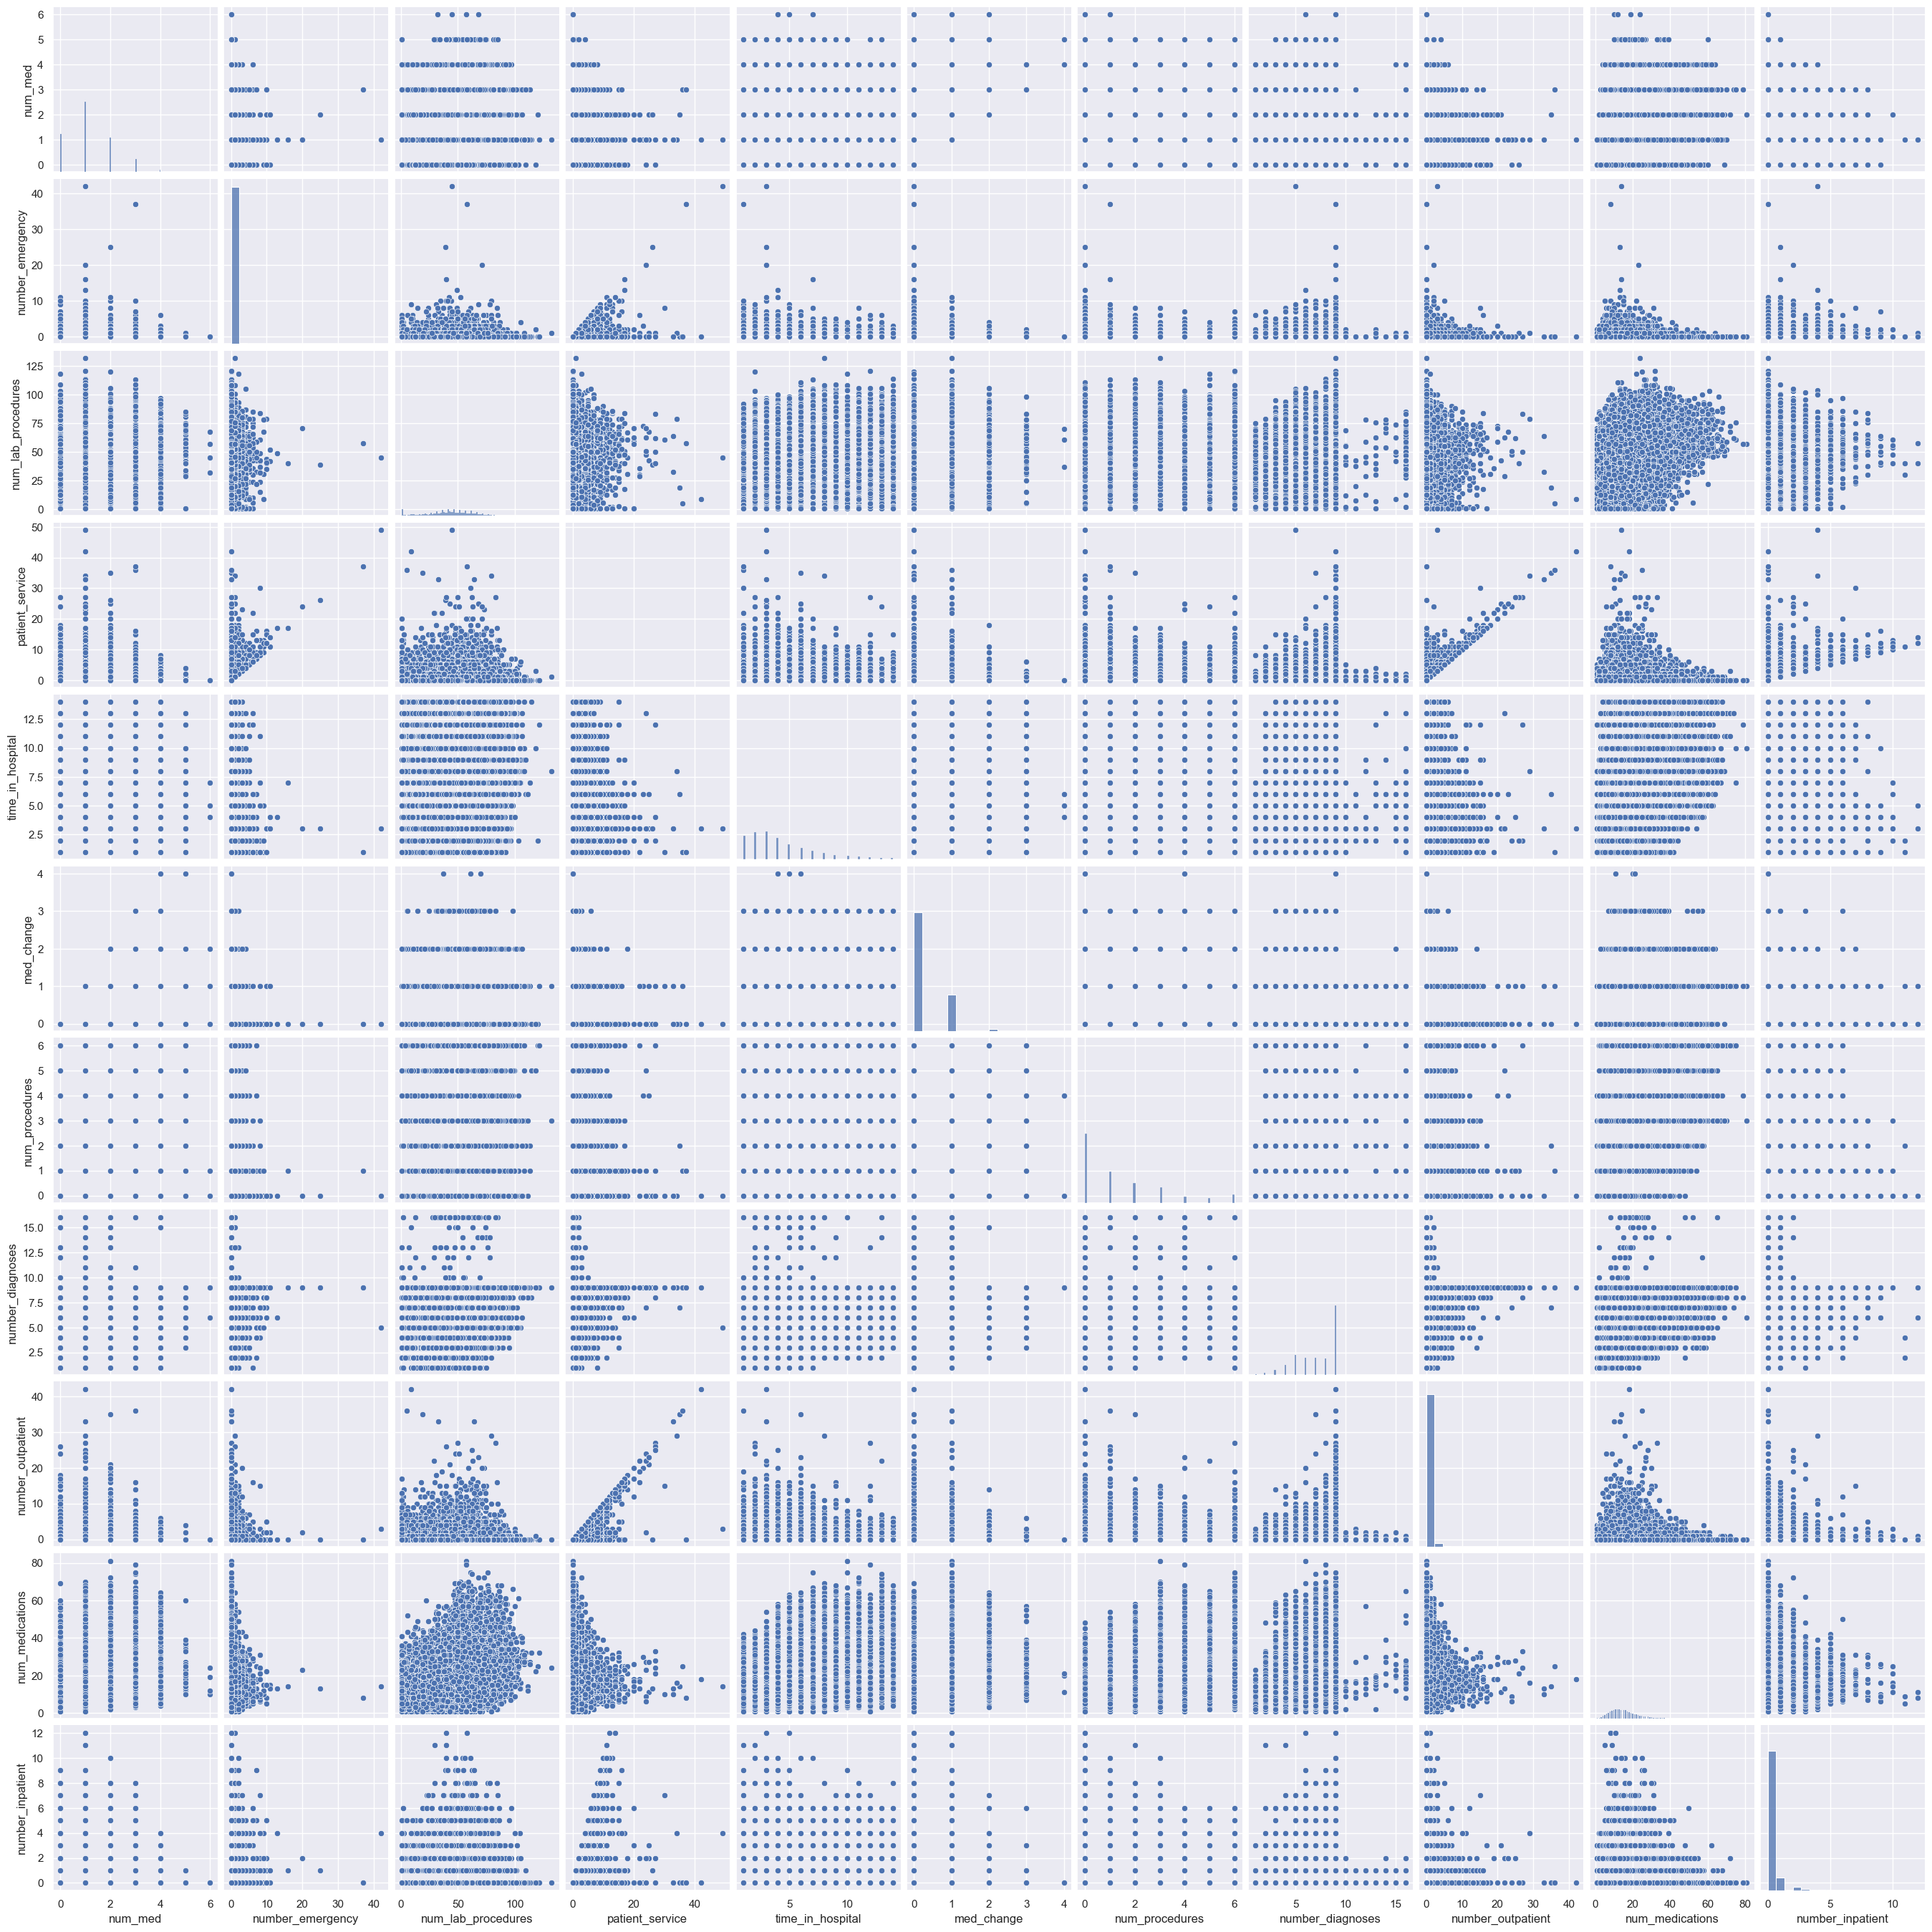

In [63]:
# Plot scatter plot to Visualise the distribution of numerical variables
sns.set()
cols = ['num_med',
 'number_emergency',
 'num_lab_procedures',
 'patient_service',
 'time_in_hospital',
 'med_change',
 'num_procedures',
 'number_diagnoses',
 'number_outpatient',
 'num_medications',
 'number_inpatient']

sns.pairplot(train[cols], height = 2.5)
plt.show();

In [64]:
# Finding the skewness and kurtosis of the variables 
# List of variables to check
i = ['num_med', 'number_emergency', 'num_lab_procedures', 'patient_service', 'time_in_hospital',
             'med_change', 'num_procedures', 'number_diagnoses', 'number_outpatient', 'num_medications',
             'number_inpatient']

# Print skewness
print("Skewness:")
print(train[i].skew())

# Print kurtosis
print("\nKurtosis:")
print(train[i].kurt())

Skewness:
num_med                0.665100
number_emergency      21.192445
num_lab_procedures    -0.219822
patient_service        6.679508
time_in_hospital       1.174483
med_change             1.603038
num_procedures         1.231202
number_diagnoses      -0.730749
number_outpatient      9.655933
num_medications        1.433054
number_inpatient       5.588750
dtype: float64

Kurtosis:
num_med                  0.192444
number_emergency      1208.011743
num_lab_procedures      -0.298613
patient_service         97.815587
time_in_hospital         0.992578
med_change               2.069199
num_procedures           0.571764
number_diagnoses        -0.365075
number_outpatient      183.579795
num_medications          3.854472
number_inpatient        47.357249
dtype: float64


In [65]:
# The analysis of skewness and kurtosis reveals that several numerical variables in the dataset
# show significant skewness and/or high kurtosis, indicating distancing from normal distribution. 

# Skewness thresholds:
# - Highly skewed: Skewness less than -1 or greater than 1.
# - Moderately skewed: Skewness between -1 and -0.5 or between 0.5 and 1.
# - Approximately symmetric: Skewness between -0.5 and 0.5.

# Kurtosis thresholds:
# - High kurtosis (> 3) indicates heavy tails and a peaked distribution with more outliers.
# - Kurtosis close to 3 indicates a distribution similar to the normal distribution.
# - Low kurtosis (< 3) suggests light tails and fewer outliers.

# Based on skewness and kurtosis thresholds,the variables requiring transformation are:
# 1. number_emergency (high skewness and very high kurtosis)
# 2. number_outpatient (high skewness and very high kurtosis)
# 3. number_inpatient (high skewness and very high kurtosis)
# 4. patient_service (high skewness and very high kurtosis)
# 5. time_in_hospital (moderately skewed and slightly high kurtosis)
# 6. med_change (moderately skewed and moderately high kurtosis)
# 7. num_procedures (moderately skewed and slightly above normal kurtosis)
# 8. num_medications (moderately skewed and high kurtosis)

In [66]:
# Log transformation for the skewed numerical variables
key = ['num_med', 'number_emergency', 'num_lab_procedures', 'patient_service', 'time_in_hospital',
               'med_change', 'num_procedures', 'number_diagnoses', 'number_outpatient', 'num_medications',
               'number_inpatient']

for col in key:
    # Apply log transformation to skewed columns and print new skewness values
    if abs(train[col].skew()) >= 1:
        if train[col].min() >= 0:
            train[col + "_log"] = np.log1p(train[col])
            print([col + "_log"], train[col + "_log"].skew())
        else:
            print(f'Column {col} contains negative values cannot be log transformed')

# Standardisation
def standardize(data):
    # Standardizes each column to have mean 0 and standard deviation 1.
    std_dev = np.std(data, axis=0)
    std_dev[std_dev == 0] = 1
    mean = np.mean(data, axis=0)
    return (data - mean) / std_dev

# Applying standardization to identified numeric features
train[num_col] = standardize(train[num_col])

# Correlation Analysis
# Remove columns 'unnamed', case-insensitive from 'train', if there are columns without headers
train = train.drop(columns=train.columns[train.columns.str.contains('unnamed', case=False)])

# Calculate correlation matrix for numeric columns
train_col = train.corr(numeric_only=True)
print(train_col)

['number_emergency_log'] 4.263367308736293
['patient_service_log'] 1.9105312588899506
['time_in_hospital_log'] 0.1327953857471521
['med_change_log'] 1.2998332686045888
['num_procedures_log'] 0.45417567379965695
['number_outpatient_log'] 3.1494234183885834
['num_medications_log'] -0.43889988043932204
['number_inpatient_log'] 3.131415968774467
                            age  time_in_hospital  num_lab_procedures  \
age                    1.000000          0.128643            0.026592   
time_in_hospital       0.128643          1.000000            0.332154   
num_lab_procedures     0.026592          0.332154            1.000000   
num_procedures        -0.024465          0.188016            0.043685   
num_medications        0.054466          0.467922            0.259088   
number_outpatient      0.026753         -0.015460           -0.007751   
number_emergency      -0.047469         -0.009854            0.015294   
number_inpatient       0.015591          0.063647            0.079858   

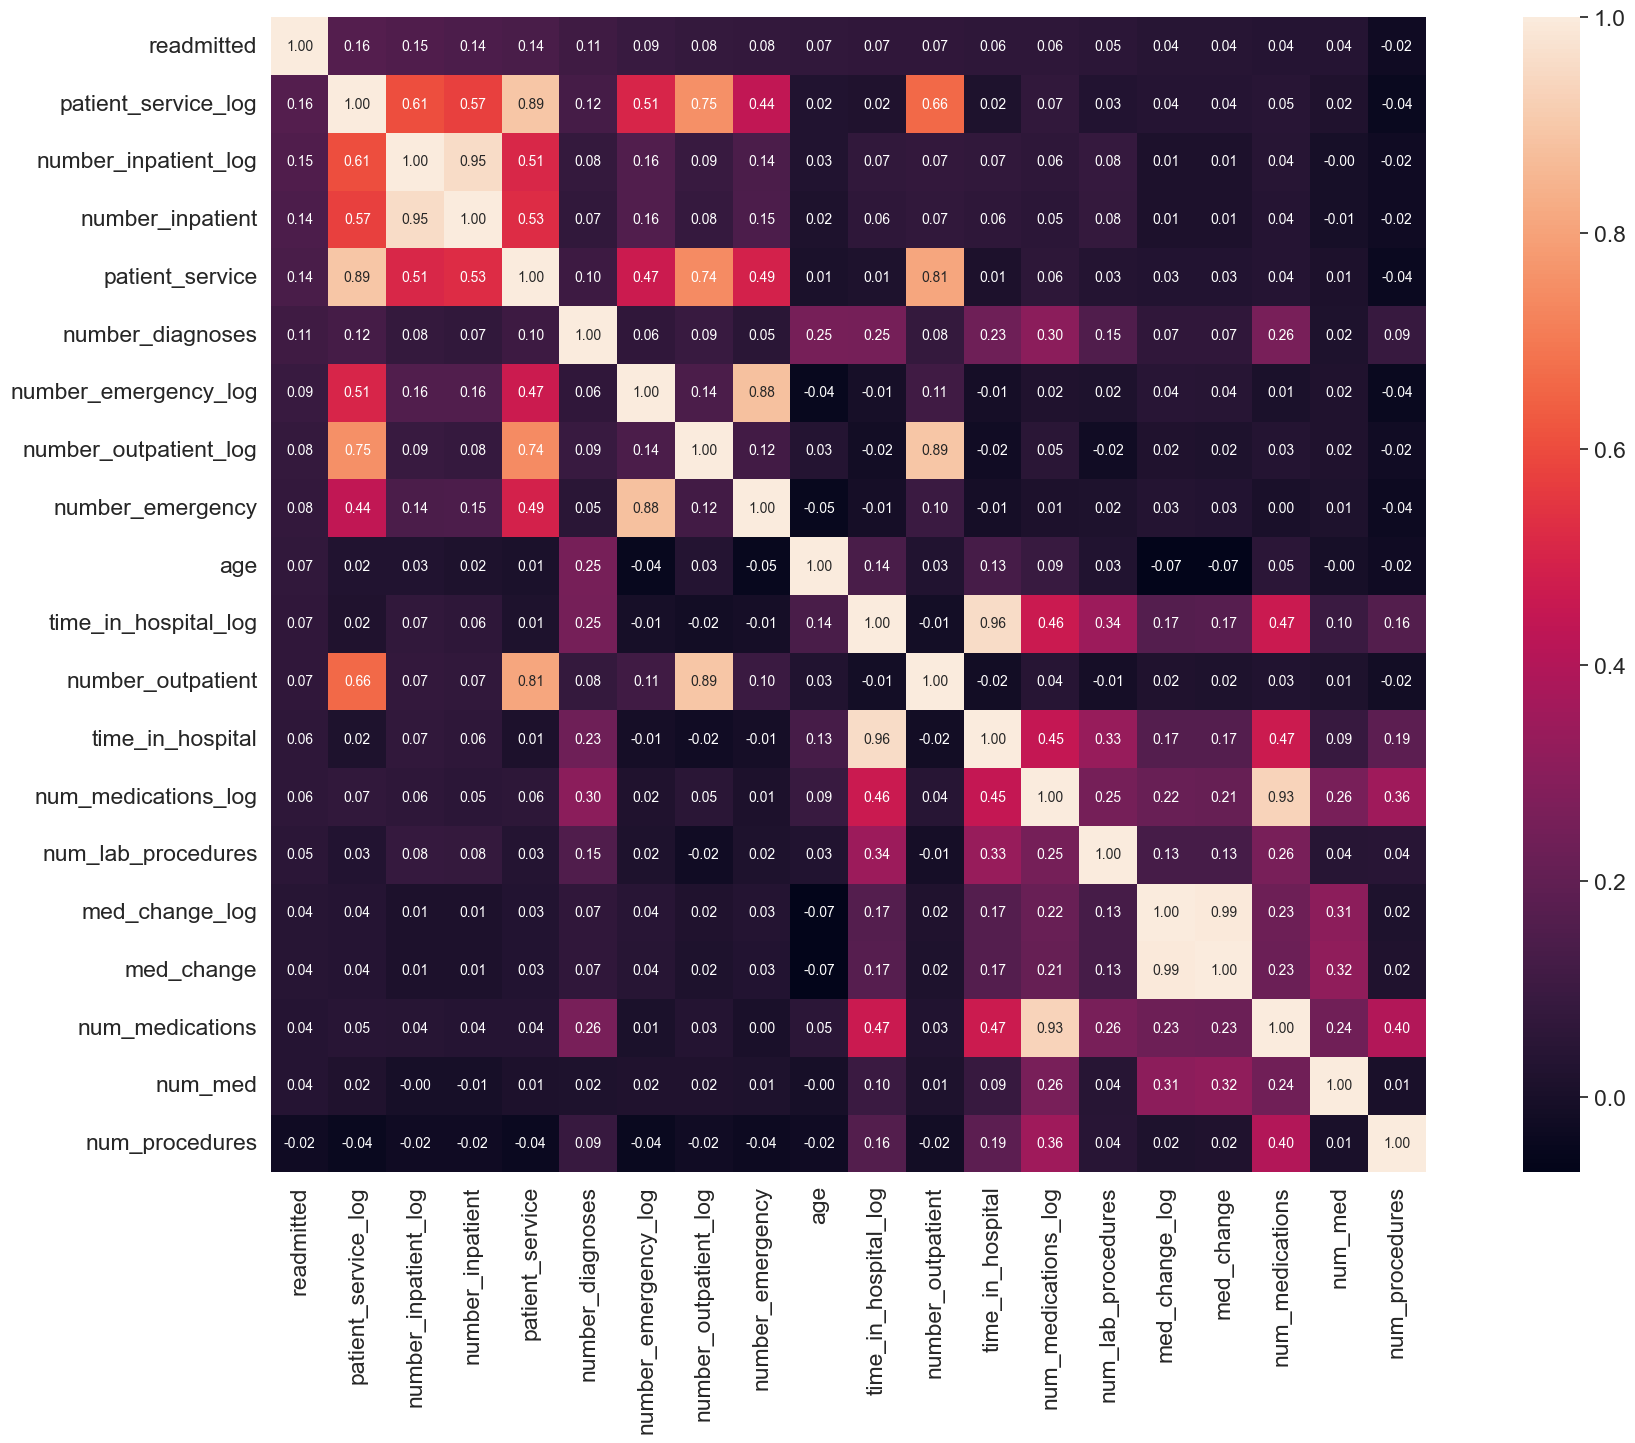

In [67]:
# Find the top 20 correlated variables "readmitted"
k = 20
cols = train_col.nlargest(k,'readmitted')['readmitted'].index 
cm = np.corrcoef(train[cols].values.T)  # Calculates the correlation matrix.
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(25, 15))
# heatmap with the correlation matrix
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, ax=ax)
plt.show()

In [68]:
# Transform 'diabetesMed' and 'change' columns type
train.diabetesMed = train.diabetesMed.astype('int64')
train.change = train.change.astype('int64')

In [69]:
# List of features that need processing.
i = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
     'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
     'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
     'metformin-pioglitazone', 'A1Cresult']

# Convert the columns to float to handle NaN values, then convert to int64
for column in i:
    train[column] = train[column].astype(float).fillna(0).astype('int64')

# Check the data types of the dataframe after transofrmation.
train.dtypes

race                         object
gender                       object
age                         float64
admission_type_id            object
discharge_disposition_id     object
admission_source_id          object
time_in_hospital            float64
num_lab_procedures          float64
num_procedures              float64
num_medications             float64
number_outpatient           float64
number_emergency            float64
number_inpatient            float64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses            float64
max_glu_serum                object
A1Cresult                     int64
metformin                     int64
repaglinide                   int64
nateglinide                   int64
chlorpropamide                int64
glimepiride                   int64
acetohexamide                 int64
glipizide                     int64
glyburide                     int64
tolbutamide                 

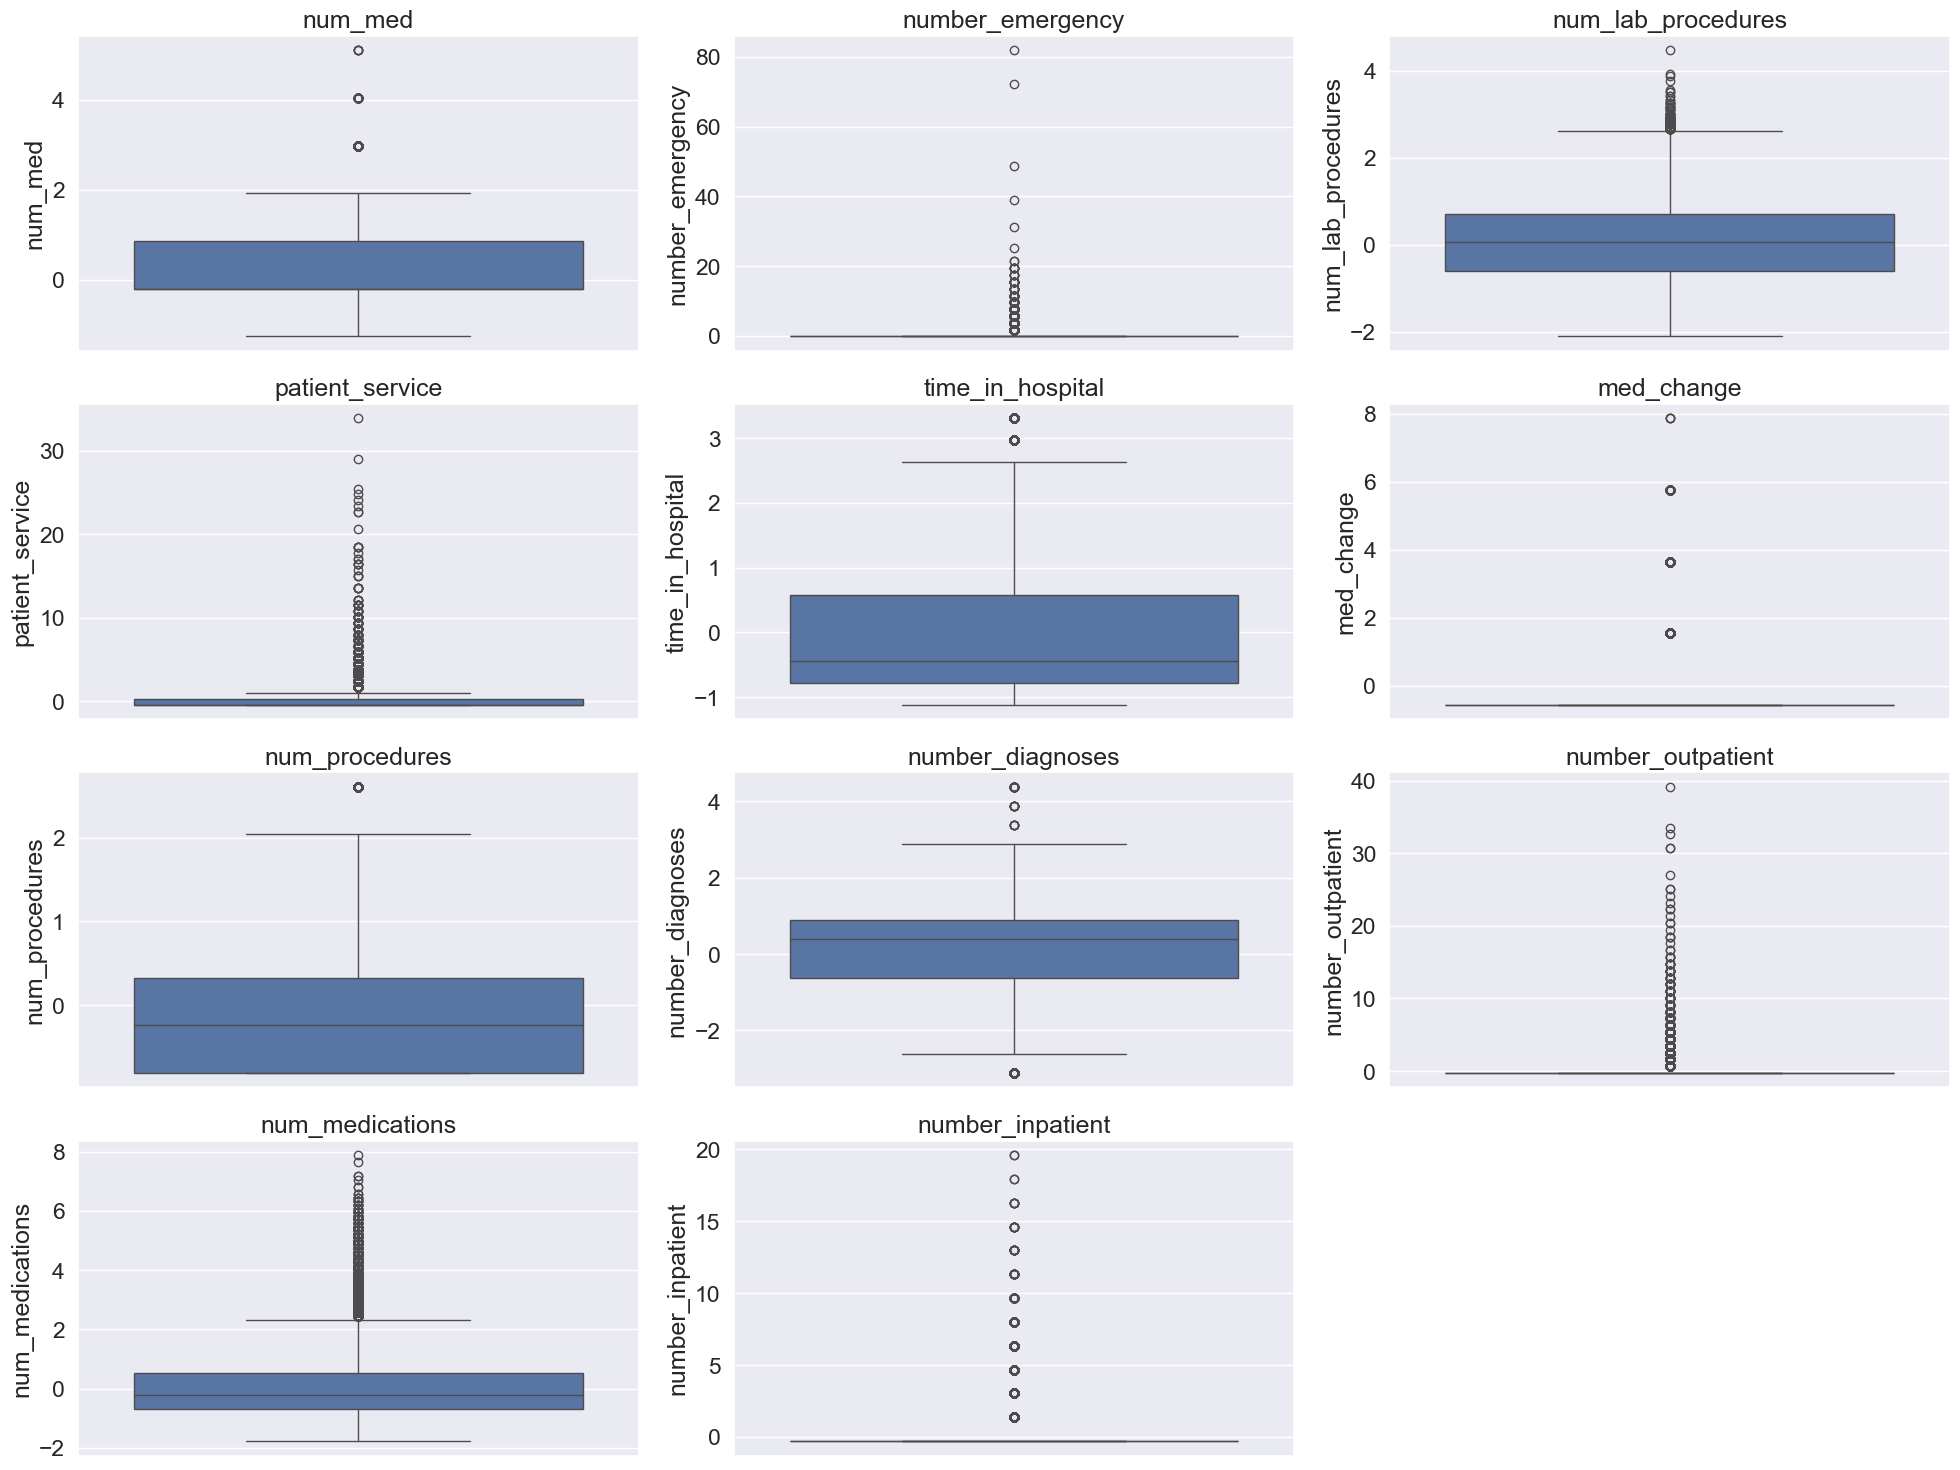

In [70]:
# Outliers
key = ['num_med', 'number_emergency', 'num_lab_procedures', 'patient_service', 'time_in_hospital', 'med_change', 
       'num_procedures', 'number_diagnoses', 'number_outpatient', 'num_medications', 'number_inpatient']

plt.figure(figsize=(20, 15))

# Boxplots for each column in 'key'
for i, col in enumerate(key):
    plt.subplot(len(key) // 3 + 1, 3, i + 1)
    sns.boxplot(y=train[col])
    plt.title(col)

plt.tight_layout()
plt.show()

In [71]:
# Dictionary to hold the outlier values for each column
outliers_dict = {}

for col in key:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter and save the actual outlier values
    outliers = train[(train[col] < lower_bound) | (train[col] > upper_bound)][col]
    outliers_dict[col] = outliers

# Print out the outliers for each column
for col, values in outliers_dict.items():
    print(f"Outliers in {col}:")
    print(values)


Outliers in num_med:
599       2.98524
728       2.98524
1022      2.98524
1165      2.98524
1224      2.98524
           ...   
101195    2.98524
101289    2.98524
101440    2.98524
101443    2.98524
101588    2.98524
Name: num_med, Length: 1058, dtype: float64
Outliers in number_emergency:
12        1.753173
60        1.753173
167       1.753173
199       1.753173
246       1.753173
            ...   
101745    1.753173
101749    1.753173
101755    1.753173
101756    1.753173
101758    1.753173
Name: number_emergency, Length: 5132, dtype: float64
Outliers in num_lab_procedures:
106       2.667257
336       3.018989
623       2.717504
823       3.119484
830       3.018989
            ...   
99591     2.817999
100351    2.667257
100457    2.868247
101541    2.767752
101587    2.918494
Name: num_lab_procedures, Length: 119, dtype: float64
Outliers in patient_service:
2         1.706575
130       1.706575
167       3.805560
172       1.706575
246       1.706575
            ...   
101636 

In [72]:
# Outliers
key = ['num_med', 'number_emergency', 'num_lab_procedures', 'patient_service', 'time_in_hospital', 'med_change', 
       'num_procedures', 'number_diagnoses', 'number_outpatient', 'num_medications','number_inpatient']

# Using IQR to filter out outliers in each column in key
for col in key:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train = train[(train[col] >= lower_bound) & (train[col] <= upper_bound)]

# Display the names of all columns in the 'train' DataFrame.
train.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'patient_service', 'med_change', 'num_med', 'primary_diag',
       'secondary_diag', 'additional_diag', 'number_emergency_log',
       'patient_service_log', 'time_in_hospital_log', 'med_change_log',
 

In [73]:
# Count of unique values
for i in train.columns:
    df = train[i].value_counts()
    print(df)

race
1    26283
2     6937
0     1683
3      760
4      276
Name: count, dtype: int64
gender
0    19380
1    16559
Name: count, dtype: int64
age
 0.593502    9154
-0.032390    7774
-0.658281    6274
 1.219393    5978
-1.284173    3440
-1.910064    1354
 1.845284    1055
-2.535955     517
-3.161847     278
-3.787738     115
Name: count, dtype: int64
admission_type_id
1    25831
3     6669
5     3433
4        6
Name: count, dtype: int64
discharge_disposition_id
1     27027
2      6478
18     2152
7       217
28       43
10       21
27        1
Name: count, dtype: int64
admission_source_id
7     19298
1     11625
4      2882
9      2124
8         6
11        4
Name: count, dtype: int64
time_in_hospital
-0.776804    7121
-0.436624    6910
-1.116983    6333
-0.096444    4933
 0.243736    3319
 0.583915    2416
 0.924095    1701
 1.264275    1160
 1.604454     736
 1.944634     540
 2.284814     441
 2.624994     329
Name: count, dtype: int64
num_lab_procedures
-2.106247    1284
 0.004144   

In [74]:
# Convert 'primary_diag' column values to integers for consistency.
train['primary_diag'] = train['primary_diag'].astype('int')
train['secondary_diag'] = train['secondary_diag'].astype('int')
train['additional_diag'] = train['additional_diag'].astype('int')

In [75]:
# Creating dummy variables for the categorical columns and removing first level do avoid dummy trap
train_v = pd.get_dummies(train, columns=['race', 'gender', 'admission_type_id', 'discharge_disposition_id',
    'admission_source_id', 'max_glu_serum', 'A1Cresult', 'primary_diag', 'secondary_diag', 'additional_diag'], drop_first=True)
print(train_v.columns.tolist())

['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted', 'patient_service', 'med_change', 'num_med', 'number_emergency_log', 'patient_service_log', 'time_in_hospital_log', 'med_change_log', 'num_procedures_log', 'number_outpatient_log', 'num_medications_log', 'number_inpatient_log', 'race_1', 'race_2', 'race_3', 'race_4', 'gender_1', 'admission_type_id_3', 'admission_type_id_4', 'admission_type_id_5', 'discharge_disposition_id_2', 'discharge_disposition_id_

In [76]:
# List of categorical columns to be processed.
nom_cols = ['age','race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'max_glu_serum', 'A1Cresult', 'primary_diag','secondary_diag', 'additional_diag' ]

# Generate a list of the numerical columns
num_cols = list(set(list(train._get_numeric_data().columns))- {'readmitted', 'change'})
num_cols

['patient_service',
 'num_medications',
 'rosiglitazone',
 'tolbutamide',
 'num_medications_log',
 'tolazamide',
 'number_emergency',
 'time_in_hospital_log',
 'additional_diag',
 'med_change_log',
 'glyburide',
 'metformin',
 'number_outpatient',
 'metformin-rosiglitazone',
 'number_inpatient_log',
 'glipizide',
 'number_inpatient',
 'age',
 'glimepiride-pioglitazone',
 'repaglinide',
 'num_procedures_log',
 'troglitazone',
 'nateglinide',
 'glimepiride',
 'num_med',
 'miglitol',
 'insulin',
 'diabetesMed',
 'patient_service_log',
 'num_procedures',
 'acetohexamide',
 'number_diagnoses',
 'glipizide-metformin',
 'number_outpatient_log',
 'secondary_diag',
 'metformin-pioglitazone',
 'A1Cresult',
 'primary_diag',
 'number_emergency_log',
 'chlorpropamide',
 'med_change',
 'acarbose',
 'glyburide-metformin',
 'pioglitazone',
 'num_lab_procedures',
 'time_in_hospital']

In [77]:
# Initialise list for new column names from dummy variables
nom_cols_new = []
for i in nom_cols:
    for j in train_v.columns:
        if i in j:
            nom_cols_new.append(j)

nom_cols_new

['age',
 'race_1',
 'race_2',
 'race_3',
 'race_4',
 'gender_1',
 'admission_type_id_3',
 'admission_type_id_4',
 'admission_type_id_5',
 'discharge_disposition_id_2',
 'discharge_disposition_id_7',
 'discharge_disposition_id_10',
 'discharge_disposition_id_18',
 'discharge_disposition_id_27',
 'discharge_disposition_id_28',
 'admission_source_id_4',
 'admission_source_id_7',
 'admission_source_id_8',
 'admission_source_id_9',
 'admission_source_id_11',
 'max_glu_serum_1',
 'max_glu_serum_99',
 'A1Cresult_1',
 'A1Cresult_99',
 'primary_diag_1',
 'primary_diag_2',
 'primary_diag_3',
 'primary_diag_4',
 'primary_diag_5',
 'primary_diag_6',
 'primary_diag_7',
 'primary_diag_8',
 'secondary_diag_1',
 'secondary_diag_2',
 'secondary_diag_3',
 'secondary_diag_4',
 'secondary_diag_5',
 'secondary_diag_6',
 'secondary_diag_7',
 'secondary_diag_8',
 'additional_diag_1',
 'additional_diag_2',
 'additional_diag_3',
 'additional_diag_4',
 'additional_diag_5',
 'additional_diag_6',
 'additional_dia

In [78]:
# Define feature set for the models: Including encoded categories, processed numerical variables, and log-transformed variables.

feature_set = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 
 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 
 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 
 'diabetesMed', 'patient_service', 'med_change', 'num_med', 'number_emergency_log', 'patient_service_log', 'time_in_hospital_log', 
 'med_change_log', 'num_procedures_log', 'number_outpatient_log', 'num_medications_log', 'number_inpatient_log', 'race_1', 'race_2', 'race_3', 
 'race_4', 'gender_1', 'admission_type_id_3', 'admission_type_id_4', 'admission_type_id_5', 'discharge_disposition_id_2', 
 'discharge_disposition_id_7', 'discharge_disposition_id_10', 'discharge_disposition_id_18', 'discharge_disposition_id_27', 
 'discharge_disposition_id_28', 'admission_source_id_4', 'admission_source_id_7', 'admission_source_id_8', 'admission_source_id_9', 
 'admission_source_id_11', 'A1Cresult_1', 'primary_diag_1', 'primary_diag_2', 'primary_diag_3', 'primary_diag_4', 
 'primary_diag_5', 'primary_diag_6', 'primary_diag_7', 'primary_diag_8', 'secondary_diag_1', 'secondary_diag_2', 'secondary_diag_3', 
 'secondary_diag_4', 'secondary_diag_5', 'secondary_diag_6', 'secondary_diag_7', 'secondary_diag_8', 'additional_diag_1', 'additional_diag_2', 
 'additional_diag_3', 'additional_diag_4', 'additional_diag_5', 'additional_diag_6', 'additional_diag_7', 'additional_diag_8']

## Modeling

Class 0 (Not Readmitted): 23444
Class 1 (Readmitted): 12495
Proportion: 1.88 : 1


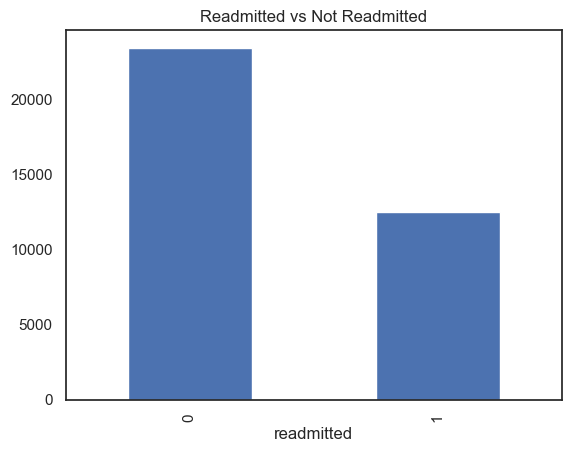

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
sns.set(style='white', context='notebook', palette='deep')

# Splitting the data into features and target variable
train_input = train_v[feature_set]
train_output = train_v['readmitted']

# Check the target variable proportions
target_count=train_v['readmitted'].value_counts()
print('Class 0 (Not Readmitted):', target_count[0])
print('Class 1 (Readmitted):', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Readmitted vs Not Readmitted')

X = train_v.drop('readmitted', axis=1)
y = train_v['readmitted']

# Split the training and testing dataset 
x_train, x_test, y_train, y_test= model_selection.train_test_split(train_input, train_output, random_state = 0, test_size=0.3)

## Logistic Regression (Baseline)

Accuracy: 0.6563
Precision: 0.4869
Recall: 0.1061
F1 Score: 0.1742
Cross-Validation Scores: [0.65470228 0.60489705 0.65358932 0.65470228 0.65804118 0.63856427
 0.64718976 0.64440735 0.65470228 0.65237963]
Mean Cross-Validation Score: 0.6463


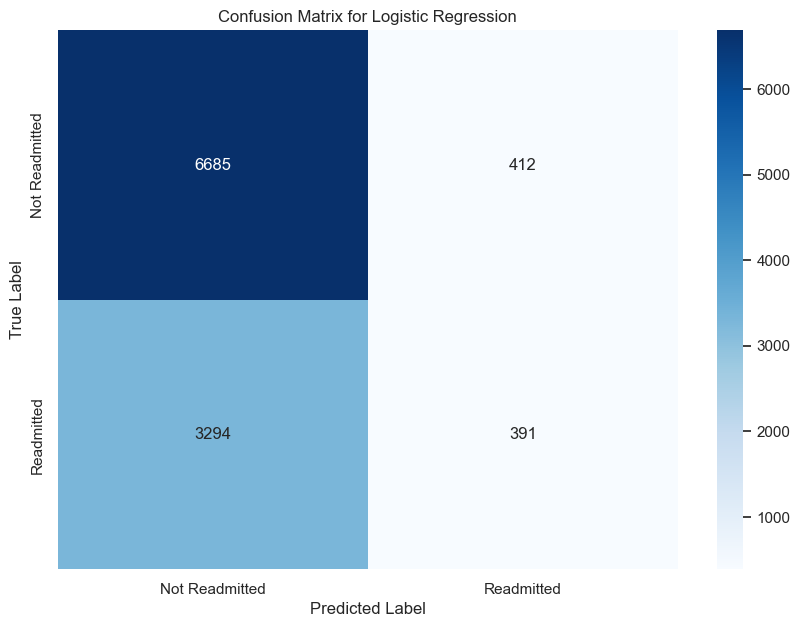

In [80]:
for column in train_v.select_dtypes(include=['object']).columns:
    # Convert object columns to categorical and replace with their integer codes for logistic regression model compatibility
    train_v[column] = train_v[column].astype('category').cat.codes

# Split the data (70% training, 30% testing)
X = train_v.drop('readmitted', axis=1)  # Features
y = train_v['readmitted']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression(max_iter=10000)

# Fit the model
logreg.fit(X_train, y_train)

# Predict the outcomes on the testing data
y_pred = logreg.predict(X_test)

# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Cross Validation
cv_scores = cross_val_score(logreg, X, y, cv=10)
mean_cv_score = cv_scores.mean()

# Print performance metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Cross-Validation Score: {mean_cv_score:.4f}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualise the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
plt.title('Confusion Matrix for Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


## Balancing

In [81]:
# Separate majority and minority classes
df_majority = train_v[train_v.readmitted==0]
df_minority = train_v[train_v.readmitted==1]

print("Initial sizes and proportions:")
print("Class 0 (Not Readmitted):", len(df_majority))
print("Class 1 (Readmitted):", len(df_minority))
print("Proportion:", round(len(df_majority) / len(df_minority), 2), ": 1")

# Oversample minority class
df_minority_oversampled = df_minority.sample(n=len(df_majority), replace=True, random_state=0)
df_oversampled = pd.concat([df_majority, df_minority_oversampled])

# Splitting the oversampled dataset into input and output
train_input_new = df_oversampled[feature_set]
train_output_new = df_oversampled['readmitted']

# Print sizes and proportions after balancing
print("\nSizes and proportions after balancing:")
print("Class 0 (Not Readmitted):", len(df_majority))
print("Class 1 (Readmitted) after oversampling:", len(df_minority_oversampled))
print("Proportion after balancing:", "1 : 1")

# Split the data (70% training, 30% testing)
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(train_input_new, train_output_new, test_size=0.3, random_state=0)

Initial sizes and proportions:
Class 0 (Not Readmitted): 23444
Class 1 (Readmitted): 12495
Proportion: 1.88 : 1

Sizes and proportions after balancing:
Class 0 (Not Readmitted): 23444
Class 1 (Readmitted) after oversampling: 23444
Proportion after balancing: 1 : 1


## RandomForest

RandomForest - Balanced Data - Accuracy: 0.8257
RandomForest - Balanced Data - Precision: 0.8307
RandomForest - Balanced Data - Recall: 0.8155


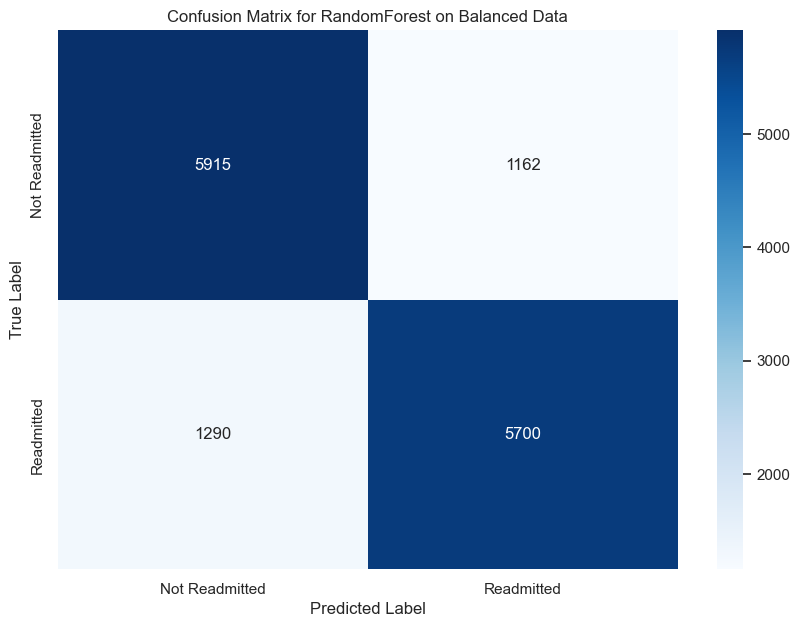

Cross-validation scores: [0.78678038 0.79981718 0.77818403 0.79981718 0.79981718 0.79677026
 0.80499695 0.8031688  0.79402803 0.79890311]
Mean cross-validation score for RandomForest: 0.7962
RandomForest - OOB Score: 0.8054
Classification Report for RandomForest on Balanced Data:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83      7077
           1       0.83      0.82      0.82      6990

    accuracy                           0.83     14067
   macro avg       0.83      0.83      0.83     14067
weighted avg       0.83      0.83      0.83     14067



In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

# Split the balanced data (70% training, 30% testing)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(train_input_new, train_output_new, test_size=0.3, random_state=0)

# Initialize RandomForest classifier
random_forest = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=0)

# Fit the model on the balanced training data
random_forest.fit(X_train_new, y_train_new)

# Predict the outcomes on the balanced testing data
y_pred_rf = random_forest.predict(X_test_new)

# Performance metrics for the balanced dataset
accuracy_rf = accuracy_score(y_test_new, y_pred_rf)
precision_rf = precision_score(y_test_new, y_pred_rf)
recall_rf = recall_score(y_test_new, y_pred_rf)

# Print performance metrics
print(f'RandomForest - Balanced Data - Accuracy: {accuracy_rf:.4f}')
print(f'RandomForest - Balanced Data - Precision: {precision_rf:.4f}')
print(f'RandomForest - Balanced Data - Recall: {recall_rf:.4f}')

# Generate the confusion matrix
conf_matrix_rf = confusion_matrix(y_test_new, y_pred_rf)

# Visualise the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
plt.title('Confusion Matrix for RandomForest on Balanced Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Perform cross-validation and calculate scores
cv_scores_rf = cross_val_score(random_forest, X_train_new, y_train_new, cv=10)

# Calculate the mean of the cross-validation scores
cv_scores_mean_rf = cv_scores_rf.mean()

# Print the cross-validation scores for each fold
print("Cross-validation scores:", cv_scores_rf)

# Print the mean of the cross-validation scores
print(f"Mean cross-validation score for RandomForest: {cv_scores_mean_rf:.4f}")

# Print the OOB score
print(f'RandomForest - OOB Score: {random_forest.oob_score_:.4f}')

# Classification report
classification_report_rf = classification_report(y_test_new, y_pred_rf)
print("Classification Report for RandomForest on Balanced Data:\n", classification_report_rf)

## Feature Importance

In [83]:
# Generate and display feature importances
feature_importances = random_forest.feature_importances_
features = X_train_new.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
pd.set_option('display.max_rows', None)
print(importance_df)
pd.reset_option('display.max_rows')

                        Feature  Importance
2            num_lab_procedures    0.083766
8                        diag_1    0.075379
9                        diag_2    0.072631
10                       diag_3    0.069968
44          num_medications_log    0.060880
4               num_medications    0.060667
0                           age    0.047899
11             number_diagnoses    0.044456
1              time_in_hospital    0.038994
40         time_in_hospital_log    0.038933
3                num_procedures    0.026400
42           num_procedures_log    0.026286
50                     gender_1    0.018441
37                      num_med    0.017528
82            additional_diag_1    0.012690
54   discharge_disposition_id_2    0.012631
46                       race_1    0.012593
61        admission_source_id_7    0.011818
27                      insulin    0.011710
74             secondary_diag_1    0.011436
47                       race_2    0.011181
66               primary_diag_1 

## Feature Set 2

In [84]:
# Selecting 23 most important features filtered
feature_set2 = [
    "num_lab_procedures",
    "diag_1",
    "diag_2",
    "diag_3",
    "num_medications_log",
    "num_medications",
    "age",
    "number_diagnoses",
    "time_in_hospital",
    "time_in_hospital_log",
    "num_procedures",
    "num_procedures_log",
    "gender_1",
    "num_med",
    "admission_source_id_7",
    "discharge_disposition_id_2",
    "additional_diag_1",
    "race_1",
    "secondary_diag_1",
    "insulin",
    "race_2",
    "primary_diag_1",
    "A1Cresult_1"
]

In [85]:
train_input_new = df_oversampled[feature_set2]
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(train_input_new, train_output_new, test_size=0.3, random_state=0)

## RandomForest 2

RandomForest - Balanced Data - Accuracy: 0.8220
RandomForest - Balanced Data - Precision: 0.8295
RandomForest - Balanced Data - Recall: 0.8079


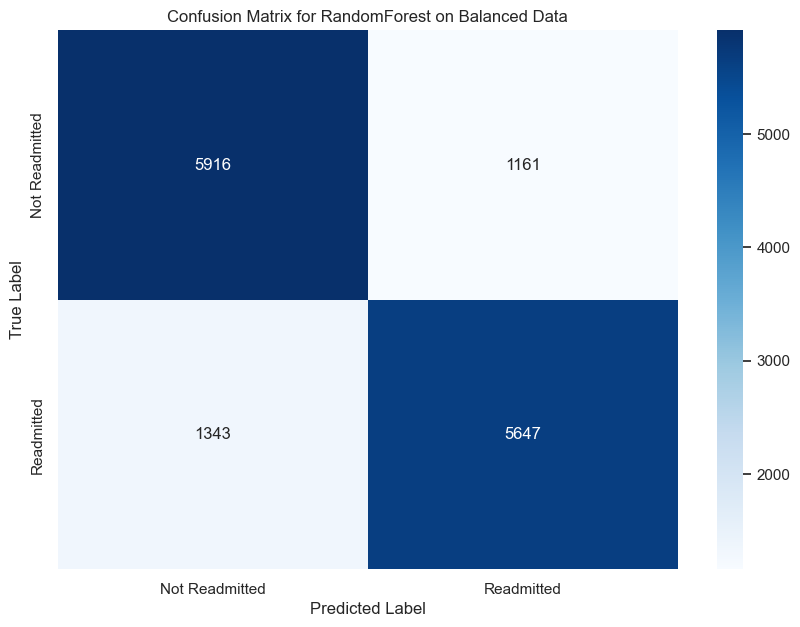

Cross-validation scores for each fold: [0.777947   0.79646557 0.77757465 0.79890311 0.79280926 0.78153565
 0.79890311 0.80225472 0.79037172 0.79280926]
Mean cross-validation score for RandomForest: 0.7910
RandomForest - OOB Score: 0.8039
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.83      7077
           1       0.83      0.81      0.82      6990

    accuracy                           0.82     14067
   macro avg       0.82      0.82      0.82     14067
weighted avg       0.82      0.82      0.82     14067



In [86]:
# Split the balanced data into training and testing sets (70% training, 30% testing)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(train_input_new, train_output_new, test_size=0.3, random_state=0)

# Initialize RandomForest classifier
random_forest = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=0)

# Fit the model on the balanced training data
random_forest.fit(X_train_new, y_train_new)

# Predict the outcomes
y_pred_rf = random_forest.predict(X_test_new)

# Performance metrics for the balanced dataset
accuracy_rf = accuracy_score(y_test_new, y_pred_rf)
precision_rf = precision_score(y_test_new, y_pred_rf)
recall_rf = recall_score(y_test_new, y_pred_rf)

# Print performance metrics for the balanced dataset
print(f'RandomForest - Balanced Data - Accuracy: {accuracy_rf:.4f}')
print(f'RandomForest - Balanced Data - Precision: {precision_rf:.4f}')
print(f'RandomForest - Balanced Data - Recall: {recall_rf:.4f}')

# Generate the confusion matrix for the balanced dataset
conf_matrix_rf = confusion_matrix(y_test_new, y_pred_rf)

# Visualise the confusion matrix for the balanced dataset
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
plt.title('Confusion Matrix for RandomForest on Balanced Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Perform cross-validation and calculate scores
cv_scores_rf = cross_val_score(random_forest, X_train_new, y_train_new, cv=10)

# Calculate the mean of the cross-validation scores
cv_scores_mean_rf = cv_scores_rf.mean()

# Print the cross-validation scores for each fold
print("Cross-validation scores for each fold:", cv_scores_rf)

# Print the mean of the cross-validation scores
print(f"Mean cross-validation score for RandomForest: {cv_scores_mean_rf:.4f}")

# Print the OOB score
print(f'RandomForest - OOB Score: {random_forest.oob_score_:.4f}')

# Classification report
classification_report_rf = classification_report(y_test_new, y_pred_rf)
print("Classification Report:\n", classification_report_rf)

## K-means Clustering

In [87]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Selecting the features for KMeans
feature_Kmeans = [
    "num_lab_procedures",
    "num_medications_log",
    "num_medications",
    "age",
    "time_in_hospital",
]

train_input_new = train_input_new[feature_Kmeans]

# Normalisation of the features
train_input_new = (train_input_new - train_input_new.min()) / (train_input_new.max() - train_input_new.min())

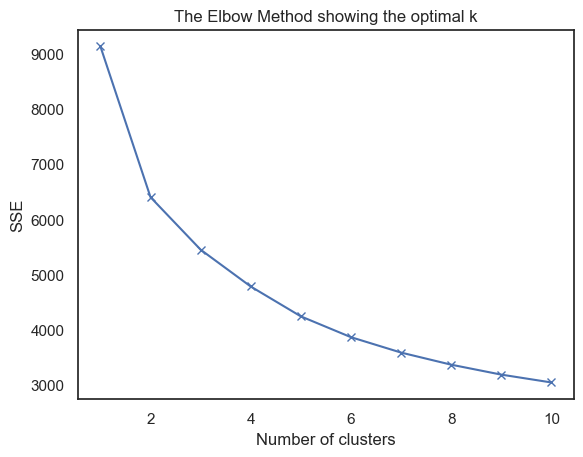

In [88]:
# Determine the optimal number of clusters using the Elbow Method
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=0).fit(train_input_new)
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [89]:
# Optimal number of clusters is 4 based on the elbow method
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, max_iter=1000, random_state=0).fit(train_input_new)
clusters = kmeans.labels_
train_input_new['cluster'] = clusters

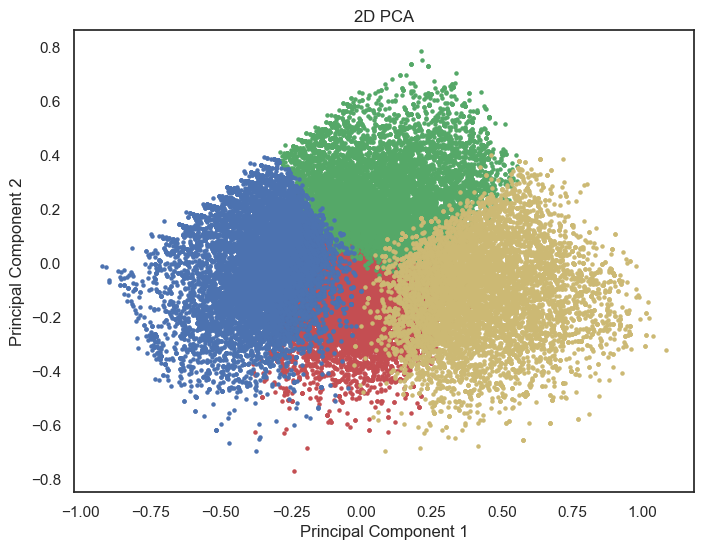

         num_lab_procedures  num_medications_log  num_medications       age  \
cluster                                                                       
0                  0.547767             0.654697         0.355210  0.720135   
1                  0.284759             0.804412         0.569895  0.671286   
2                  0.296647             0.477429         0.200640  0.610642   
3                  0.562398             0.819973         0.604744  0.719008   

         time_in_hospital  
cluster                    
0                0.213076  
1                0.182417  
2                0.109253  
3                0.596763  


In [90]:
# PCA visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train_input_new.drop('cluster', axis=1))
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Combine PCA and cluster labels
finalDf = pd.concat([principalDf, train_input_new[['cluster']].reset_index(drop=True)], axis=1)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA')

colors = ['r', 'g', 'b', 'y', 'c', 'm']
for cluster in range(optimal_k):
    cluster_data = finalDf[finalDf['cluster'] == cluster]
    plt.scatter(cluster_data['principal component 1'], 
                cluster_data['principal component 2'], 
                c=colors[cluster], 
                s=5)
plt.show()

# Grouping the data by the 'cluster' column and calculating the mean for each group
cluster_means = train_input_new.groupby('cluster').mean()
print(cluster_means)

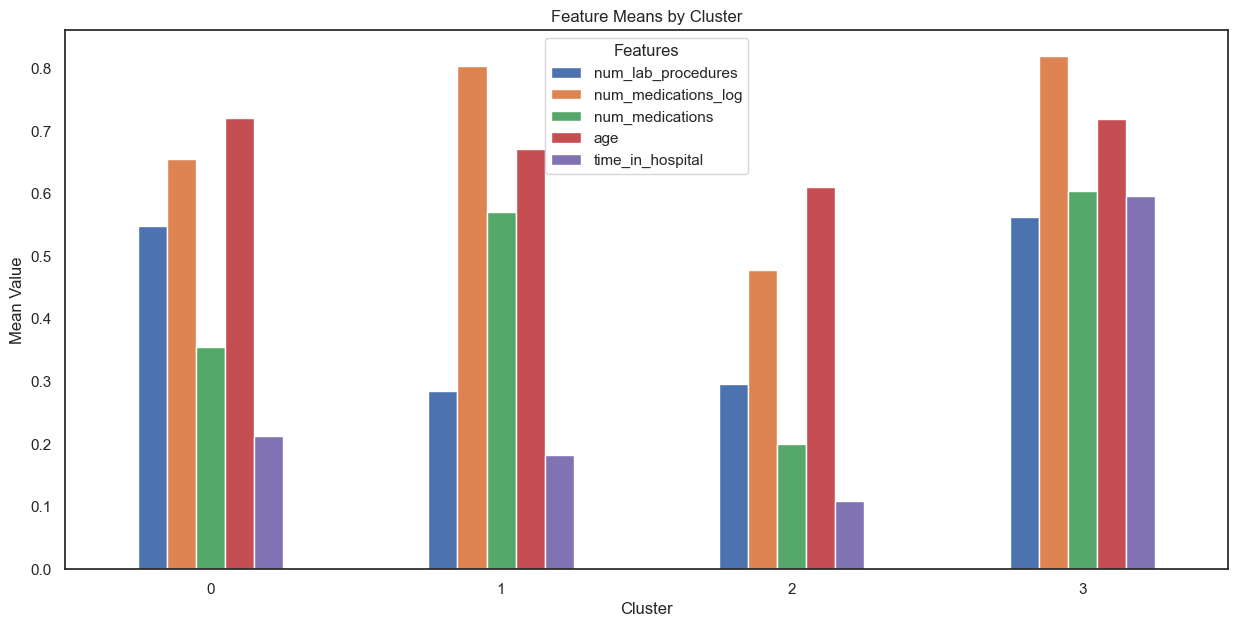

In [91]:
# Bar plot visualizing the means for each feature by cluster.
cluster_means.plot(kind='bar', figsize=(15, 7))
plt.title('Feature Means by Cluster')
plt.ylabel('Mean Value')
plt.xlabel('Cluster')
plt.xticks(rotation=0) 
plt.legend(title='Features')
plt.show()